# Simulation Analyses
This notebook contains the code to reproduce analyses related to the computational simulations for the main paper version of Visual Scoping. 

> What should we expect from following different strategies of taking future costs into account?

This notebook is organized according to the topic sentences, which can be found in the tex file of the manuscript.
For human data and model fitting, see other notebooks in this folder.

Requires:

* `.pkl` files generated by `experiment/simulate_agents.*.py` (which in turn need `.pkl` files that hold the cached sequences)

## Setup

In [2]:
# set up imports
import os
import sys

__file__ = os.getcwd()
proj_dir = os.path.dirname(os.path.realpath(__file__))
sys.path.append(proj_dir)
utils_dir = os.path.join(proj_dir, "utils")
sys.path.append(utils_dir)
analysis_dir = os.path.join(proj_dir, "analysis")
analysis_utils_dir = os.path.join(analysis_dir, "utils")
sys.path.append(analysis_utils_dir)
agent_dir = os.path.join(proj_dir, "model")
sys.path.append(agent_dir)
agent_util_dir = os.path.join(agent_dir, "utils")
sys.path.append(agent_util_dir)
experiments_dir = os.path.join(proj_dir, "experiments")
stim_dir = os.path.join(proj_dir, "stimuli")
sys.path.append(stim_dir)
sys.path.append(experiments_dir)
df_dir = os.path.join(proj_dir, "results/dataframes")

In [3]:
from scoping_simulations.model.Subgoal_Planning_Agent import *
import scoping_simulations.utils.blockworld as bw
import scoping_simulations.utils.blockworld_library as bl
from scoping_simulations.stimuli.tower_generator import TowerGenerator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from scipy import stats
from scipy.stats import sem as sem
import math

import itertools

import random
from tqdm.notebook import tqdm
import p_tqdm

from IPython.display import clear_output

In [4]:
import re
import ast


def str2array(s):
    # strip "array" and parentheses
    s = re.sub("\[array\(", "", s.strip())
    s = re.sub("\)]", "", s.strip())
    # Remove space after [
    s = re.sub("\[ +", "[", s.strip())
    # Replace commas and spaces
    s = re.sub("[,\s]+", ", ", s)
    return np.array(ast.literal_eval(s))


def str2list(s):
    if s is np.nan:
        return s
    # strip "array" and parentheses
    s = re.sub("\[array\(", "", s.strip())
    s = re.sub("\)]", "", s.strip())
    # Remove space after [
    s = re.sub("\[ +", "[", s.strip())
    # Replace commas and spaces
    s = re.sub("[,\s]+", ", ", s)
    return list(ast.literal_eval(s))

In [5]:
# helper function for pd.agg
def item(x):
    return x.tail(1).item()

In [6]:
# inline plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Plot styling:

In [7]:
plt.rcParams["figure.figsize"] = (7, 7)
plt.rcParams.update({"font.size": 26})

In [8]:
from matplotlib import rc

# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = ['Helvetica']
rc(
    "text.latex",
    preamble=r"\usepackage{tgheros} \usepackage{newtxsf} \renewcommand{\familydefault}{\sfdefault} \usepackage{mathastext}",
)  # sets the font via latex preamble—only way to autoset tick labels?

In [9]:
# display all columns
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 20)
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.min_rows", 12)

## Loading data
Let's load the results of the experiment. Provide the path to a folder containing the dataframes genereated by `simulate_agents.*.py`

In [10]:
!pwd

/mnt/pentagon/home/AD/fbinder/tools_block_construction/analysis


In [11]:
FOLDERS = [
    "simulated_subgoal_agents__4",  # which folders do we want to load files from?
    "simulated_subgoal_agents__4",
    "simulated_subgoal_agents_best first length 4 size 9 1",
]

In [12]:
folder_path = os.path.abspath(os.path.join(os.path.pardir, "results", "dataframes"))
full_folder_paths = [os.path.join(folder_path, folder) for folder in FOLDERS]
print(f"Main results folder path is {os.path.abspath(folder_path)}")

Main results folder path is /mnt/pentagon/home/AD/fbinder/tools_block_construction/results/dataframes


In [13]:
csv_paths = [
    [
        os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if f.endswith(".csv")
    ]
    for folder_path in full_folder_paths
]
csv_paths = list(itertools.chain.from_iterable(csv_paths))
print("Got {} csv files".format(len(csv_paths)))

Got 67 csv files


In [14]:
pkl_paths = [
    [
        os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if f.endswith(".pkl")
    ]
    for folder_path in full_folder_paths
]
pkl_paths = list(itertools.chain.from_iterable(pkl_paths))
print("Got {} pkl files".format(len(pkl_paths)))

Got 67 pkl files


In [15]:
# FOR DEVELOPMENT
# cut short the file list
# pkl_paths = pkl_paths[:1]

In [16]:
# load all experiments as one dataframe from pickles—this can take a long time and use a lot of memory
dfs = []
for pkl_path in tqdm(pkl_paths):
    df_temp = pd.read_pickle(os.path.join(df_dir, pkl_path))
    df_temp["filename"] = pkl_path
    dfs.append(df_temp)

print("Read {} dataframes".format(len(dfs)))

# merge dfs
df = pd.concat(dfs)
print("Merged dataframes: {}".format(df.shape))

  0%|          | 0/67 [00:00<?, ?it/s]

Read 67 dataframes
Merged dataframes: (61667, 57)


When running the simulations, the decomposer for the No Subgoals agent was improperly set, making it impossible to solve certain towers (because no decomposition encompassing everything could be found). This has been fixed (04/18/23), but I don't want to rerun everything, so we selectively fix this by pulling out the broken rows and rerunning them in a separate file to fill them out. 

In [17]:
# get broken rows for No Subgoals
ns_failure_mask = (df["label"] == "No Subgoals") & (df["action"].isna())
print("Found {} broken rows for No Subgoals".format(ns_failure_mask.sum()))
df[ns_failure_mask].to_pickle("Simulation_Analysis_No_Subgoals_Failures.pkl")

Found 91 broken rows for No Subgoals


In [18]:
# drop the failure rows
df = df[~ns_failure_mask]

In [19]:
from importlib import reload

reload(model.utils.Simulation_Analysis_Fix_No_Subgoals)

AttributeError: module 'model.utils' has no attribute 'Simulation_Analysis_Fix_No_Subgoals'

In [24]:
run_NS_fix = True
if run_NS_fix:
    import scoping_simulations.model.utils.Simulation_Analysis_Fix_No_Subgoals

    model.utils.Simulation_Analysis_Fix_No_Subgoals.run()

Loaded dataframe with 42 rows


  0%|          | 0/42 [00:00<?, ?it/s]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


  2%|▏         | 1/42 [00:00<00:15,  2.57it/s]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


  5%|▍         | 2/42 [00:00<00:12,  3.17it/s]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


  7%|▋         | 3/42 [00:00<00:11,  3.28it/s]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 10%|▉         | 4/42 [00:01<00:11,  3.22it/s]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 12%|█▏        | 5/42 [00:01<00:12,  3.06it/s]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 14%|█▍        | 6/42 [00:01<00:11,  3.26it/s]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 17%|█▋        | 7/42 [00:02<00:09,  3.54it/s]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 19%|█▉        | 8/42 [00:02<00:09,  3.47it/s]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 21%|██▏       | 9/42 [00:04<00:24,  1.33it/s]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 24%|██▍       | 10/42 [00:04<00:22,  1.41it/s]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 26%|██▌       | 11/42 [00:05<00:26,  1.18it/s]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 29%|██▊       | 12/42 [00:28<03:45,  7.52s/it]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 31%|███       | 13/42 [00:29<02:35,  5.36s/it]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 33%|███▎      | 14/42 [00:29<01:47,  3.85s/it]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 36%|███▌      | 15/42 [00:29<01:14,  2.78s/it]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 38%|███▊      | 16/42 [00:30<00:52,  2.01s/it]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 40%|████      | 17/42 [00:31<00:47,  1.89s/it]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 43%|████▎     | 18/42 [00:32<00:39,  1.63s/it]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 45%|████▌     | 19/42 [01:26<06:37, 17.29s/it]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 48%|████▊     | 20/42 [01:26<04:29, 12.23s/it]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 50%|█████     | 21/42 [01:27<03:01,  8.63s/it]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 52%|█████▏    | 22/42 [01:27<02:02,  6.12s/it]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 55%|█████▍    | 23/42 [01:27<01:22,  4.37s/it]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 57%|█████▋    | 24/42 [01:27<00:56,  3.15s/it]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 60%|█████▉    | 25/42 [01:28<00:39,  2.31s/it]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 62%|██████▏   | 26/42 [01:29<00:31,  1.97s/it]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 64%|██████▍   | 27/42 [01:30<00:24,  1.63s/it]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 67%|██████▋   | 28/42 [01:30<00:18,  1.32s/it]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 69%|██████▉   | 29/42 [01:31<00:12,  1.01it/s]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 71%|███████▏  | 30/42 [01:31<00:09,  1.20it/s]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 74%|███████▍  | 31/42 [01:31<00:07,  1.47it/s]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 76%|███████▌  | 32/42 [01:32<00:06,  1.60it/s]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 79%|███████▊  | 33/42 [01:33<00:08,  1.11it/s]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 81%|████████  | 34/42 [01:34<00:05,  1.40it/s]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 83%|████████▎ | 35/42 [01:34<00:04,  1.62it/s]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 86%|████████▌ | 36/42 [01:35<00:03,  1.67it/s]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 88%|████████▊ | 37/42 [01:36<00:03,  1.38it/s]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 90%|█████████ | 38/42 [02:02<00:33,  8.28s/it]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 93%|█████████▎| 39/42 [02:35<00:47, 15.82s/it]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 95%|█████████▌| 40/42 [02:40<00:25, 12.69s/it]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


 98%|█████████▊| 41/42 [02:41<00:08,  8.98s/it]

Created 1 experiments
Chunked experiments into 1 chunks
Running experiment block 1 of 1


100%|██████████| 42/42 [02:41<00:00,  3.85s/it]

Done running simulations
Got 253 rows


Saved to /home/AD/fbinder/tools_block_construction/analysis/Simulation_Analysis_No_Subgoals_Failures_fixed.pkl


In [27]:
# load in the replacement rows
df_replacements = pd.read_pickle("Simulation_Analysis_No_Subgoals_Failures_fixed.pkl")
print(f"Got {len(df_replacements)} replacement rows")
# add into df
df = pd.concat([df, df_replacements])

Got 253 replacement rows


In [26]:
# for the model comparision with BFS, we want to save out a .pkl df with only the _worlds we need
worlds = df["_world"].unique()
pd.DataFrame(worlds, columns=["_world"]).to_pickle("Simulation_Analysis_Worlds.pkl")
print("Saved. Feed this into `BFS_model_comparision_for_simulation_analyses.py`")

Saved. Feed this into `BFS_model_comparision_for_simulation_analyses.py`


In [28]:
# do a few things to add helpful columns and such
# use either solution_cost or states_evaluated as cost
df["cost"] = np.maximum(
    df["partial_solution_cost"].fillna(0), df["states_evaluated"].fillna(0)
)
# do the same for total cost
df["total_cost"] = np.maximum(
    df["all_sequences_planning_cost"].fillna(0), df["states_evaluated"].fillna(0)
)

In [29]:
# add world size—note that world size is in pixels, not number of blocks in the reference solution
df["world_size"] = df["_world"].apply(lambda x: np.sum(x.full_silhouette > 0))

In [30]:
# we also want the number of subgoals considered
def count_all_seqs(sequences):
    try:
        if len(sequences) > 1:
            return len(sequences)
        elif len(sequences) == 1:
            return len(sequences[0])
        else:
            return len(sequences)
    except:
        return np.nan


df["all_sequences_count"] = df["_all_subgoal_sequences"].apply(count_all_seqs)

In [31]:
# fdf holds final rows for every run
fdf = df.groupby("run_ID").agg(
    {
        "agent": "first",
        "agent_type": item,
        "c_weight": "first",
        "label": "first",
        "world": item,
        "action": "count",
        "blockmap": "last",
        "states_evaluated": ["sum", "mean", sem],
        "planning_cost": ["sum", "mean", sem],
        "partial_planning_cost": [
            "sum",
            "mean",
            sem,
        ],  # the planning cost of the sequence as far as acted
        "partial_solution_cost": ["sum", "mean", sem],
        "solution_cost": ["sum", "mean", sem],
        "all_sequences_planning_cost": ["sum", "mean", sem],
        "all_sequences_count": "sum",
        # 'num_subgoals_acted': ['sum', 'mean', sem],
        "perfect": "last",
        "planning_step": "max",
        "cost": ["sum", "mean", sem],
        "total_cost": ["sum", "mean", sem],
        "world_size": item,
    }
)

# flatten the dataframe to remove multi-index for next groupby
fdf.columns = [" ".join(col).strip() for col in fdf.columns.values]
fdf.reset_index(inplace=True)
# What is the number of blocks used?
# fdf['num_blocks'] = fdf['blockmap last'].apply(lambda x: np.max(str2array(x)))
# store note order as categorical to ensure sort
# fdf['note item'] = pd.Categorical(fdf['note item'],NOTE_ORDER) #restore the order of column

## Helper functions

In [32]:
# extraction functions
def CI95(data):  # this is NOT bootstrapped
    #     return st.t.interval(alpha=0.95,df=len(data)-1,loc=np.mean(data),scale=st.sem(data))
    return tuple(np.percentile(data, [2.5, 97.5]))


def names(list_names):
    if list_names is np.nan:
        return np.nan
    return [g for g in list_names if g is not np.nan]

### Bootstrapping

In [33]:
def bootstrap_over_runs(
    df, column, stat_function=np.mean, CIs=[2.5, 97.5], iterations=1000, show_tqdm=True
):
    """Bootstrap by choosing individual runs across towers (`run_ID`).
    The given df should only contain rows for the relevant algorithm/conditions.
    Returns mean and CI of mean."""
    measurements = np.zeros(iterations)
    for i in tqdm(range(iterations), leave=False, disable=not show_tqdm):
        # sample with replacement
        run = df.sample(frac=1, replace=True)[column]
        # save that run
        measurements[i] = stat_function(run)
    # compute mean and CI over measurements
    return (
        np.mean(measurements),
        np.percentile(measurements, CIs),
        stat_function(df[column]),
    )

### Plotting

In [34]:
def get_shape(label):
    if label == "No Subgoal":
        return "o"
    if label == "Myopic":
        return "s"
    if label == "Lookahead":
        return "^"
    if label == "Lookahead 2":
        return "v"
    # if "Full Decomp" in label: return "d"
    if label == "Full Decomp 3":
        return "d"
    if label == "Full Decomp 4":
        return "D"
    return "o"

In [35]:
def get_colors(label):
    if label == "Myopic":
        return "limegreen"
    if label == "Lookahead 1":
        return "cornflowerblue"
    if label == "Lookahead 2":
        return "darkblue"
    if label == "No Subgoals":
        return "grey"
    if label == "Full Decomp":
        return "hotpink"
    if label == "Full Decomp 3":
        return "hotpink"
    if label == "Full Decomp 4":
        return "purple"
    # if 'Myopic' in label:
    #     return [43/255,108/255,162/255,]
    # elif 'Lookahead' in label:
    #     return [150/255,43/255,162/255,]
    # elif 'Best First' in label:
    #     return [42/255,132/255,94/255,]
    # else:
    #     return [174/255,55/255,4/255,]

In [36]:
def plot_data(
    fdf,
    x_axis,
    y_axis,
    x_label,
    y_label,
    title,
    x_scale="linear",
    y_scale="log",
    legend=True,
):
    plt.figure(figsize=(7, 7))

    for label in tqdm(fdf["label first"].unique()):
        ag_df = fdf[fdf["label first"] == label]
        ag_df = ag_df.sort_values(by=x_axis)
        jitter = np.random.normal(0, 0.5, ag_df.shape[0])

        plt.scatter(
            ag_df[x_axis] + jitter,
            ag_df[y_axis],
            alpha=0.33,
            marker=get_shape(label),
            color=get_colors(label),
        )

        means = []
        cis = []

        for size in ag_df[x_axis].unique():
            mean, ci, true_mean = bootstrap_over_runs(
                ag_df[ag_df[x_axis] == size],
                y_axis,
                stat_function=np.mean,
                show_tqdm=False,
            )
            means.append(mean)
            cis.append(ci)

        plt.plot(
            ag_df[x_axis].unique(),
            means,
            color=get_colors(label),
            marker=get_shape(label),
            markersize=10,
            label=label,
        )
        plt.fill_between(
            ag_df[x_axis].unique(),
            [c[0] for c in cis],
            [c[1] for c in cis],
            alpha=0.2,
            color=get_colors(label),
        )

    plt.yscale(y_scale)
    plt.xscale(x_scale)
    if legend:
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    # plt.show()
    # return the plot object
    return plt.gcf()

## Analyses

### Solving these towers by doing action level search alone is hard.

In [37]:
df[df["label"] == "No Subgoals"].sample(3)

run_ID  \
627  Blockworld_6_{'agent_type': 'Simulated_Subgoal_Agent', 'c_weight': 1, 'step_size': -1, 'random_s...   
737  Blockworld_27_{'agent_type': 'Simulated_Subgoal_Agent', 'c_weight': 1, 'step_size': -1, 'random_...   
698  Blockworld_89_{'agent_type': 'Simulated_Subgoal_Agent', 'c_weight': 1, 'step_size': -1, 'random_...   

                       agent  \
627  Simulated_Subgoal_Agent   
737  Simulated_Subgoal_Agent   
698  Simulated_Subgoal_Agent   

             world  \
627   Blockworld_6   
737  Blockworld_27   
698  Blockworld_89   

     step  \
627   3.0   
737   1.0   
698   0.0   

     planning_step  \
627            1.0   
737            1.0   
698            1.0   

     states_evaluated  \
627               NaN   
737               NaN   
698               NaN   

             action  \
627  ['(3x1)', '3']   
737  ['(1x3)', '4']   
698  ['(1x3)', '1']   

        _action  \
627  ((3x1), 3)   
737  ((1x3), 4)   
698  ((1x3), 1)   

     action_x  \
627       3.0   
737       4.0   
698       1.0   

     action_block_width  \
627                 3.0   
737                 1.0   
698                 1.0   

     action_block_height  \
627                  1.0   
737                  3.0   
698                  3.0   

                                                       blocks  \
627  [1x3 at (2,7), 1x3 at (6,7), 2x1 at (3,7), 3x1 at (3,6)]   
737                              [1x3 at (5,7), 1x3 at (4,7)]   
698                                            [1x3 at (1,7)]   

                                                      _blocks  \
627  [1x3 at (2,7), 1x3 at (6,7), 2x1 at (3,7), 3x1 at (3,6)]   
737                              [1x3 at (5,7), 1x3 at (4,7)]   
698                                            [1x3 at (1,7)]   

                                                                                                blockmap  \
627  [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0...   
737  [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0...   
698  [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0...   

         _world  \
627  Blockworld   
737  Blockworld   
698  Blockworld   

     legal_action_space  \
627                 1.0   
737                 1.0   
698                 1.0   

     fast_failure  \
627           0.0   
737           0.0   
698           0.0   

     execution_time  \
627             NaN   
737             NaN   
698             NaN   

    world_status  \
627          NaN   
737          NaN   
698          NaN   

    world_failure_reason  \
627                  NaN   
737                  NaN   
698                  NaN   

                                                                                        agent_attributes  \
627  {'agent_type': 'Simulated_Subgoal_Agent', 'c_weight': 1, 'step_size': -1, 'label': 'No Subgoals'...   
737  {'agent_type': 'Simulated_Subgoal_Agent', 'c_weight': 1, 'step_size': -1, 'label': 'No Subgoals'...   
698  {'agent_type': 'Simulated_Subgoal_Agent', 'c_weight': 1, 'step_size': -1, 'label': 'No Subgoals'...   

                  agent_type  \
627  Simulated_Subgoal_Agent   
737  Simulated_Subgoal_Agent   
698  Simulated_Subgoal_Agent   

     c_weight  \
627       1.0   
737       1.0   
698       1.0   

     step_size  \
627       -1.0   
737       -1.0   
698       -1.0   

     random_seed  \
627      73085.0   
737      73085.0   
698      73085.0   

           label  \
627  No Subgoals   
737  No Subgoals   
698  No Subgoals   

         parent: agent_type  \
627  Subgoal_Planning_Agent   
737  Subgoal_Planning_Agent   
698  Subgoal_Planning_Agent   

       parent: label  \
627  Subgoal Planner   
737  Subgoal Planner   
698  Subgoal Planner   

       parent: decomposition_function  \
627  Decomposition_Functions_Combined   
737  Decomposition_Functions_Combined   
698  Decomposition_

In [38]:
print("Mean success rate for no subgoals")
mean, ci, true_mean = bootstrap_over_runs(
    fdf[fdf["label first"] == "No Subgoals"], "perfect last", stat_function=np.mean
)
print("True Mean: {}, Bootstraped Mean: {}, CI: {}".format(true_mean, mean, ci))

Mean success rate for no subgoals


  0%|          | 0/1000 [00:00<?, ?it/s]

True Mean: 1.0, Bootstraped Mean: 1.0, CI: [1. 1.]


In [39]:
print("Mean Action Level Cost for no subgoals")
mean, ci, true_mean = bootstrap_over_runs(
    df[df["label"] == "No Subgoals"], "cost", stat_function=np.mean
)
print("True Mean: {}, Bootstrapped Mean: {}, CI: {}".format(true_mean, mean, ci))

Mean Action Level Cost for no subgoals


  0%|          | 0/1000 [00:00<?, ?it/s]

True Mean: 369.57056694813025, Bootstrapped Mean: 366.33572496984317, CI: [128.50983112 704.39402895]


#### Relation to tower size

In [40]:
# smallest and largest worlds cost and success rate
# bootstrap
print("Smallest worlds")
print("Smallest size: {}".format(fdf["world_size item"].min()))
mean, ci, true_mean = bootstrap_over_runs(
    fdf[fdf["world_size item"] == fdf["world_size item"].min()],
    "cost sum",
    stat_function=np.mean,
)
print(
    "*Cost sum*: True Mean: {}, Bootstrapped Mean: {}, CI: {}".format(
        true_mean, mean, ci
    )
)
mean, ci, true_mean = bootstrap_over_runs(
    fdf[fdf["world_size item"] == fdf["world_size item"].min()],
    "perfect last",
    stat_function=np.mean,
)
print(
    "*Perfect*: True Mean: {}, Bootstrapped Mean: {}, CI: {}".format(
        true_mean, mean, ci
    )
)
print("Largest world")
print("Largest size: {}".format(fdf["world_size item"].max()))
mean, ci, true_mean = bootstrap_over_runs(
    fdf[fdf["world_size item"] == fdf["world_size item"].max()],
    "cost sum",
    stat_function=np.mean,
)
print(
    "*Cost sum*: True Mean: {}, Bootstrapped Mean: {}, CI: {}".format(
        true_mean, mean, ci
    )
)
mean, ci, true_mean = bootstrap_over_runs(
    fdf[fdf["world_size item"] == fdf["world_size item"].max()],
    "perfect last",
    stat_function=np.mean,
)
print(
    "*Perfect*: True Mean: {}, Bootstrapped Mean: {}, CI: {}".format(
        true_mean, mean, ci
    )
)

Smallest worlds
Smallest size: 10


  0%|          | 0/1000 [00:00<?, ?it/s]

*Cost sum*: True Mean: 7.121951219512195, Bootstrapped Mean: 7.170579268292683, CI: [5.54207317 9.09161585]


  0%|          | 0/1000 [00:00<?, ?it/s]

*Perfect*: True Mean: 0.43902439024390244, Bootstrapped Mean: 0.4392743902439024, CI: [0.36585366 0.51829268]
Largest world
Largest size: 24


  0%|          | 0/1000 [00:00<?, ?it/s]

*Cost sum*: True Mean: 1364.219512195122, Bootstrapped Mean: 1343.2085609756098, CI: [  10.85243902 3232.30304878]


  0%|          | 0/1000 [00:00<?, ?it/s]

*Perfect*: True Mean: 0.12195121951219512, Bootstrapped Mean: 0.1198048780487805, CI: [0.02439024 0.22012195]


### The use of visual subgoals can greatly reduce the action planning costs over not using subgoals, with full decomposition reducing it most.

In [41]:
agent_summary = pd.DataFrame(
    columns=[
        "mean action level cost",
        "mean subgoal level cost",
        "mean success rate",
        "CI action level cost",
        "CI subgoal level cost",
        "CI success rate",
    ],
    index=fdf["label first"].unique(),
)
for label in tqdm(fdf["label first"].unique()):
    label_dict = {}
    # get action level cost
    mean, ci, true_mean = bootstrap_over_runs(
        fdf[fdf["label first"] == label],
        "cost sum",
        stat_function=np.mean,
        show_tqdm=False,
    )
    label_dict["mean action level cost"] = true_mean
    label_dict["CI action level cost"] = ci
    # get subgoal level cost
    mean, ci, true_mean = bootstrap_over_runs(
        fdf[fdf["label first"] == label],
        "total_cost sum",
        stat_function=np.mean,
        show_tqdm=False,
    )
    label_dict["mean subgoal level cost"] = true_mean
    label_dict["CI subgoal level cost"] = ci
    # get success rate
    mean, ci, true_mean = bootstrap_over_runs(
        fdf[fdf["label first"] == label],
        "perfect last",
        stat_function=np.mean,
        show_tqdm=False,
    )
    label_dict["mean success rate"] = true_mean
    label_dict["CI success rate"] = ci
    # add to dataframe
    agent_summary.loc[label] = label_dict
display(agent_summary)

  0%|          | 0/5 [00:00<?, ?it/s]

mean action level cost  \
Lookahead                  23.577303   
Myopic                    131.439556   
Full Decomp 3              11.820312   
No Subgoals              2393.546875   
Full Decomp 4              11.179688   

              mean subgoal level cost  \
Lookahead                49349.678043   
Myopic                   31577.852385   
Full Decomp 3             8280.804688   
No Subgoals                4787.09375   
Full Decomp 4               9798.9375   

              mean success rate  \
Lookahead              0.396793   
Myopic                 0.284951   
Full Decomp 3               1.0   
No Subgoals                 1.0   
Full Decomp 4               1.0   

                                  CI action level cost  \
Lookahead      [10.739740953947368, 43.32962582236842]   
Myopic         [46.646988075657895, 231.8638055098684]   
Full Decomp 3         [10.1484375, 14.103515624999998]   
No Subgoals       [848.2771484375, 4402.2435546874985]   
Full Decomp 4                   [9.875, 13.0783203125]   

                                 CI subgoal level cost  \
Lookahead       [43282.30388569079, 54853.39113898027]   
Myopic         [26908.993873355263, 36700.61495682566]   
Full Decomp 3       [4812.039453125, 12839.7974609375]   
No Subgoals        [1968.941796875, 8392.650781249999]   
Full Decomp 4       [5826.3466796875, 14515.523828125]   

                                          CI success rate  
Lookahead       [0.3762335526315789, 0.41489514802631583]  
Myopic         [0.26644736842105265, 0.30304276315789475]  
Full Decomp 3                                  [1.0, 1.0]  
No Subgoals                                    [1.0, 1.0]  
Full Decomp 4                                  [1.0, 1.0]

### But it comes with a cost of choosing subgoals—which makes lookahead look like the most promising strategy

Scatter plot of action, subgoal levels costs across different agents.

In [42]:
fdf.sample(3)

run_ID  \
650   Blockworld_115_{'agent_type': 'Simulated_Subgoal_Agent', 'c_weight': 4.0, 'step_size': 1, 'rando...   
3724  Blockworld_66_{'agent_type': 'Simulated_Subgoal_Agent', 'c_weight': 3.0, 'step_size': 1, 'random...   
2700  Blockworld_41_{'agent_type': 'Simulated_Subgoal_Agent', 'c_weight': 4.0, 'step_size': 1, 'random...   

                  agent first  \
650   Simulated_Subgoal_Agent   
3724  Simulated_Subgoal_Agent   
2700  Simulated_Subgoal_Agent   

              agent_type item  \
650   Simulated_Subgoal_Agent   
3724  Simulated_Subgoal_Agent   
2700  Simulated_Subgoal_Agent   

      c_weight first  \
650              4.0   
3724             3.0   
2700             4.0   

     label first  \
650       Myopic   
3724      Myopic   
2700      Myopic   

          world item  \
650   Blockworld_115   
3724   Blockworld_66   
2700   Blockworld_41   

      action count  \
650              4   
3724             4   
2700             6   

                                                                                            blockmap last  \
650   [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0...   
3724  [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 2, 0], [0, 0, 0, 0, 0, 0...   
2700  [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 2, 0], [0, 0, 0, 0, 0, 0...   

      states_evaluated sum  \
650                    0.0   
3724                   0.0   
2700                   0.0   

      states_evaluated mean  \
650                     NaN   
3724                    NaN   
2700                    NaN   

      states_evaluated sem  \
650                    NaN   
3724                   NaN   
2700                   NaN   

      planning_cost sum  \
650                 6.0   
3724                6.0   
2700               11.0   

      planning_cost mean  \
650                 2.00   
3724                2.00   
2700                2.75   

      planning_cost sem  \
650                 NaN   
3724                NaN   
2700                NaN   

      partial_planning_cost sum  \
650                         6.0   
3724                        6.0   
2700                       11.0   

      partial_planning_cost mean  \
650                         2.00   
3724                        2.00   
2700                        2.75   

      partial_planning_cost sem  \
650                         NaN   
3724                        NaN   
2700                        NaN   

      partial_solution_cost sum  \
650                         6.0   
3724                        6.0   
2700                       11.0   

      partial_solution_cost mean  \
650                         2.00   
3724                        2.00   
2700                        2.75   

      partial_solution_cost sem  \
650                         NaN   
3724                        NaN   
2700                        NaN   

      solution_cost sum  \
650                 6.0   
3724                6.0   
2700               11.0   

      solution_cost mean  \
650                 2.00   
3724                2.00   
2700                2.75   

      solution_cost sem  \
650                 NaN   
3724                NaN   
2700                NaN   

      all_sequences_planning_cost sum  \
650                          192413.0   
3724                            210.0   
2700                          29170.0   

      all_sequences_planning_cost mean  \
650                       64137.666667   
3724                         70.000000   
2700                       7292.500000   

      all_sequences_planning_cost sem  \
650                               NaN   
3724                              NaN   
2700                              NaN   

      all_sequences_count sum  \
650                     125.0   
3724                     50.0   
2700                    125.0   

      perfect last  \
650          False   
3724         False   
2700         F

### This is mediated by the size of the problem—for smaller problem full decomp might better.

  0%|          | 0/5 [00:00<?, ?it/s]

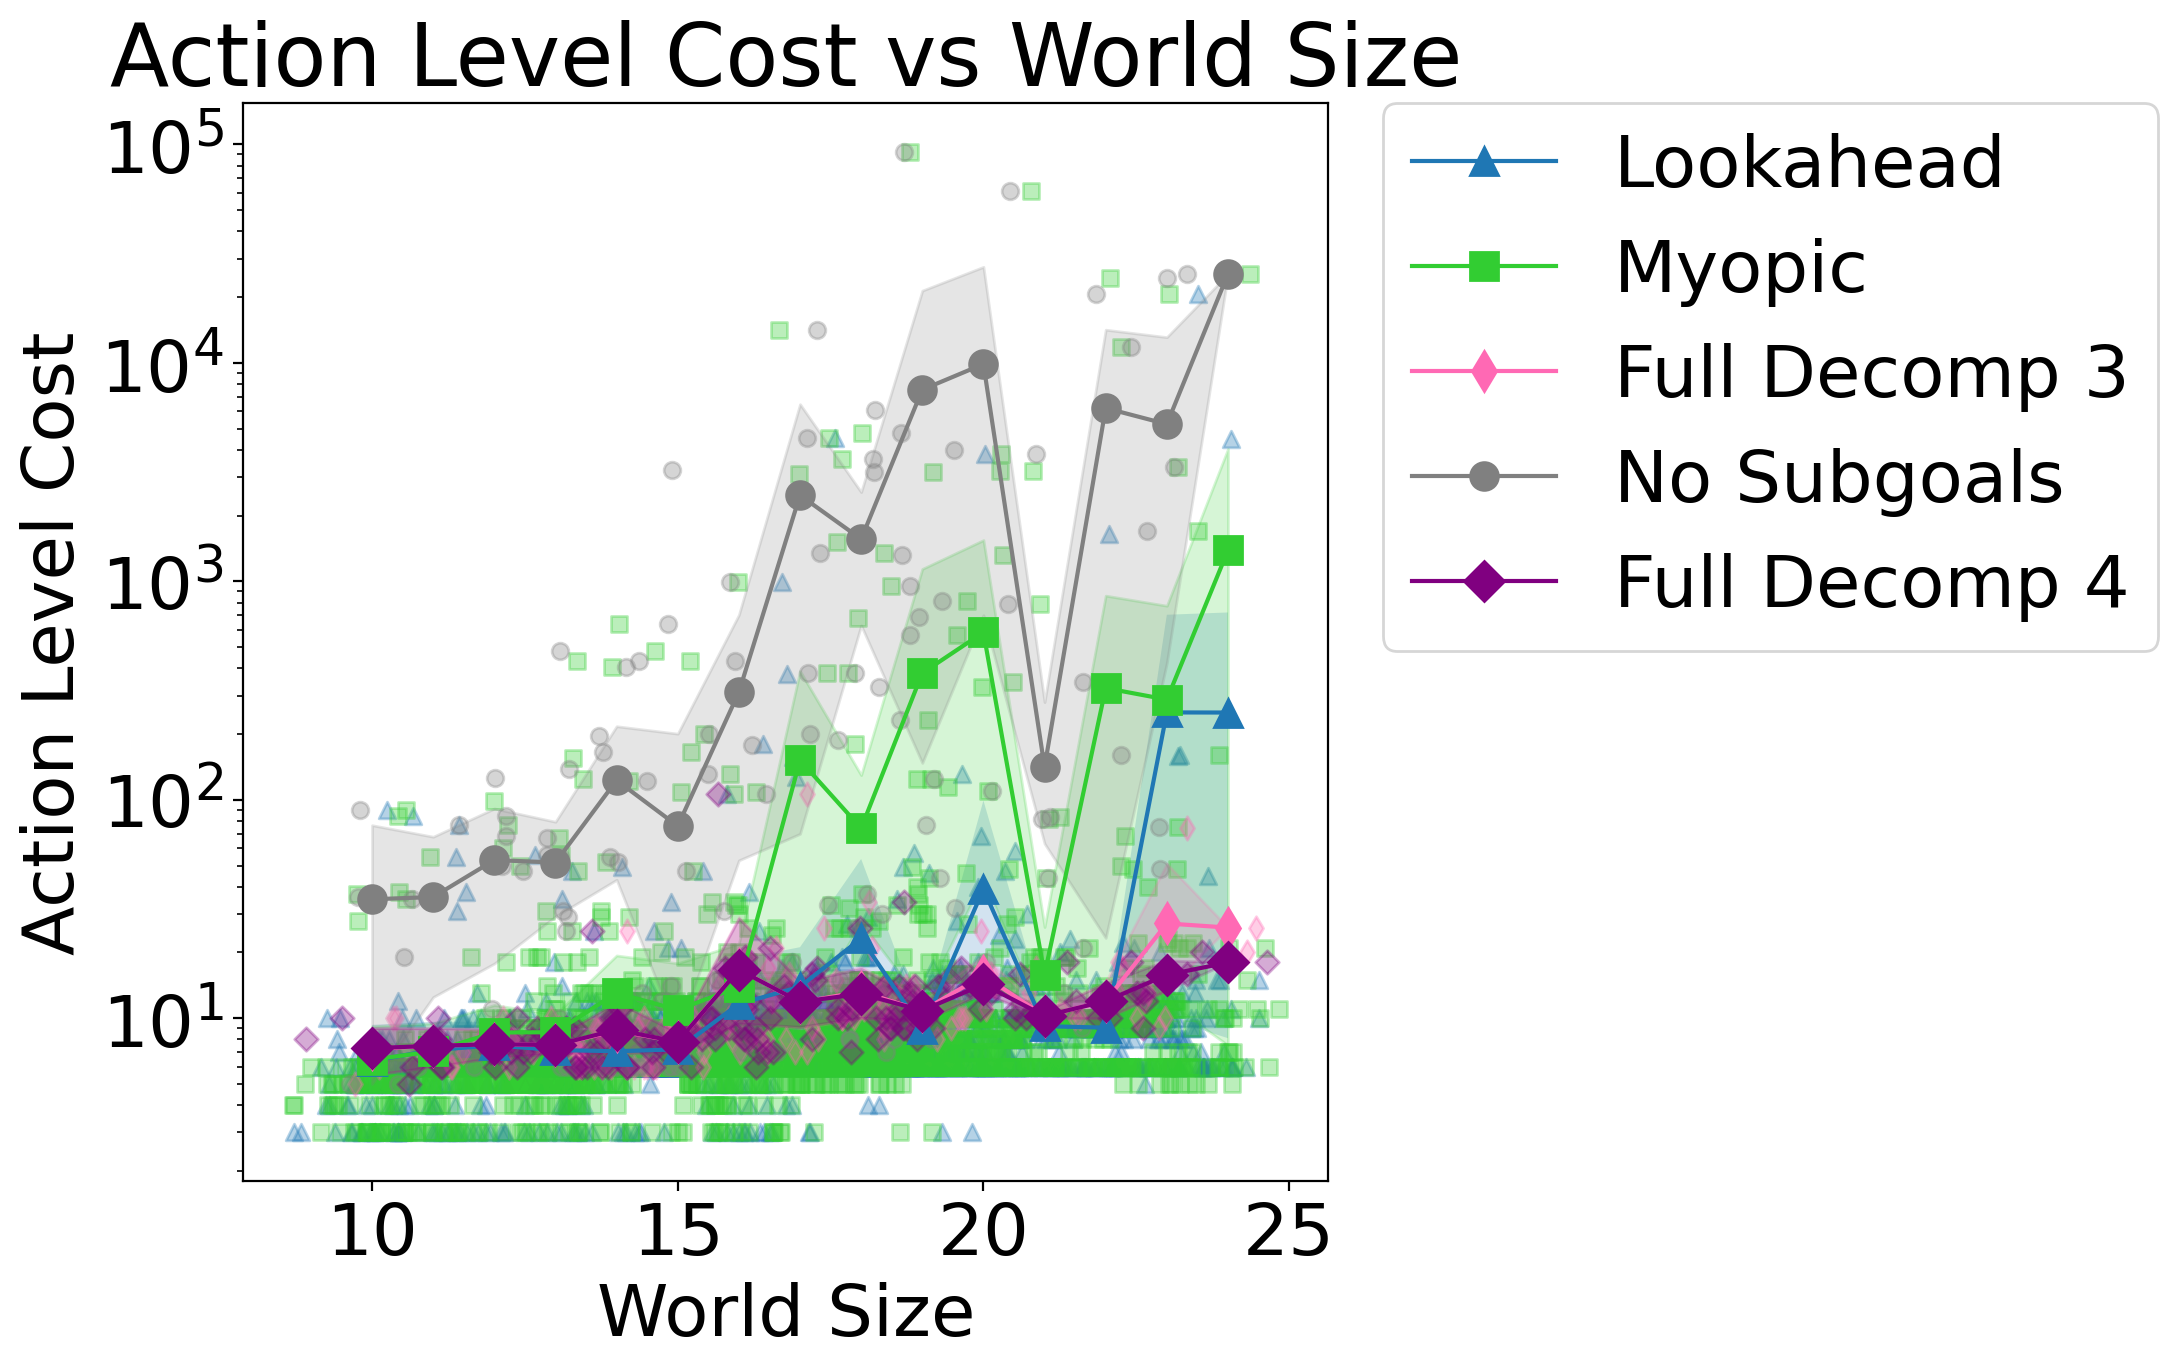

In [43]:
plot = plot_data(
    fdf,
    "world_size item",
    "cost sum",
    "World Size",
    "Action Level Cost",
    "Action Level Cost vs World Size",
)

  0%|          | 0/5 [00:00<?, ?it/s]

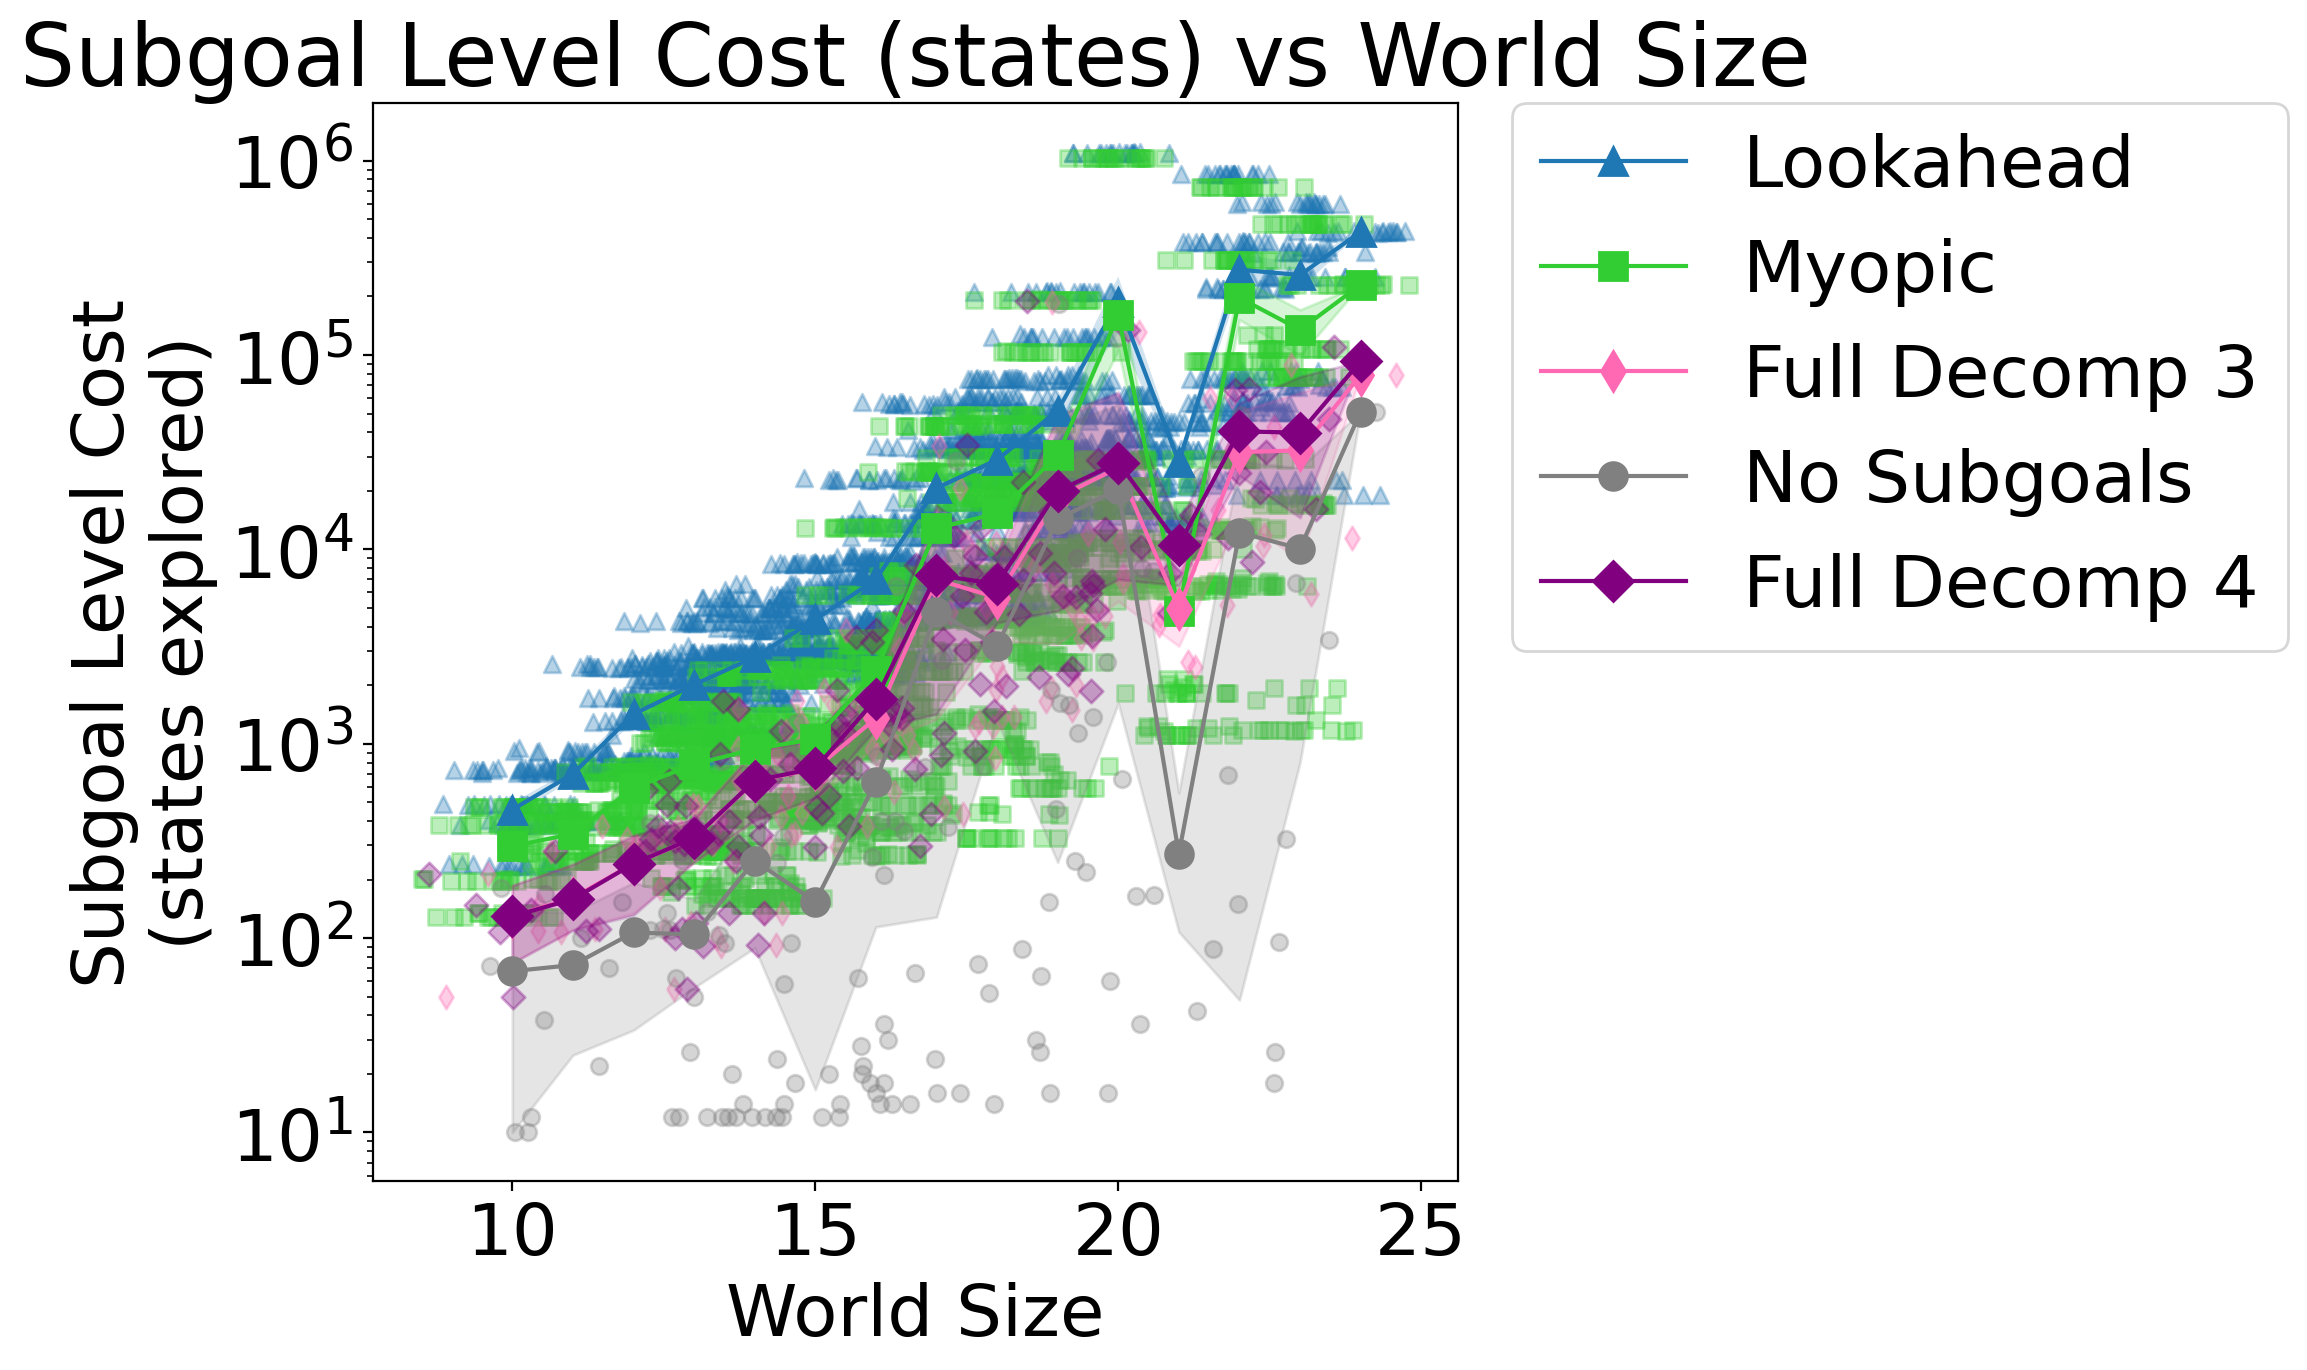

In [44]:
plot = plot_data(
    fdf,
    "world_size item",
    "total_cost sum",
    "World Size",
    "Subgoal Level Cost\n(states explored)",
    "Subgoal Level Cost (states) vs World Size",
)

  0%|          | 0/5 [00:00<?, ?it/s]

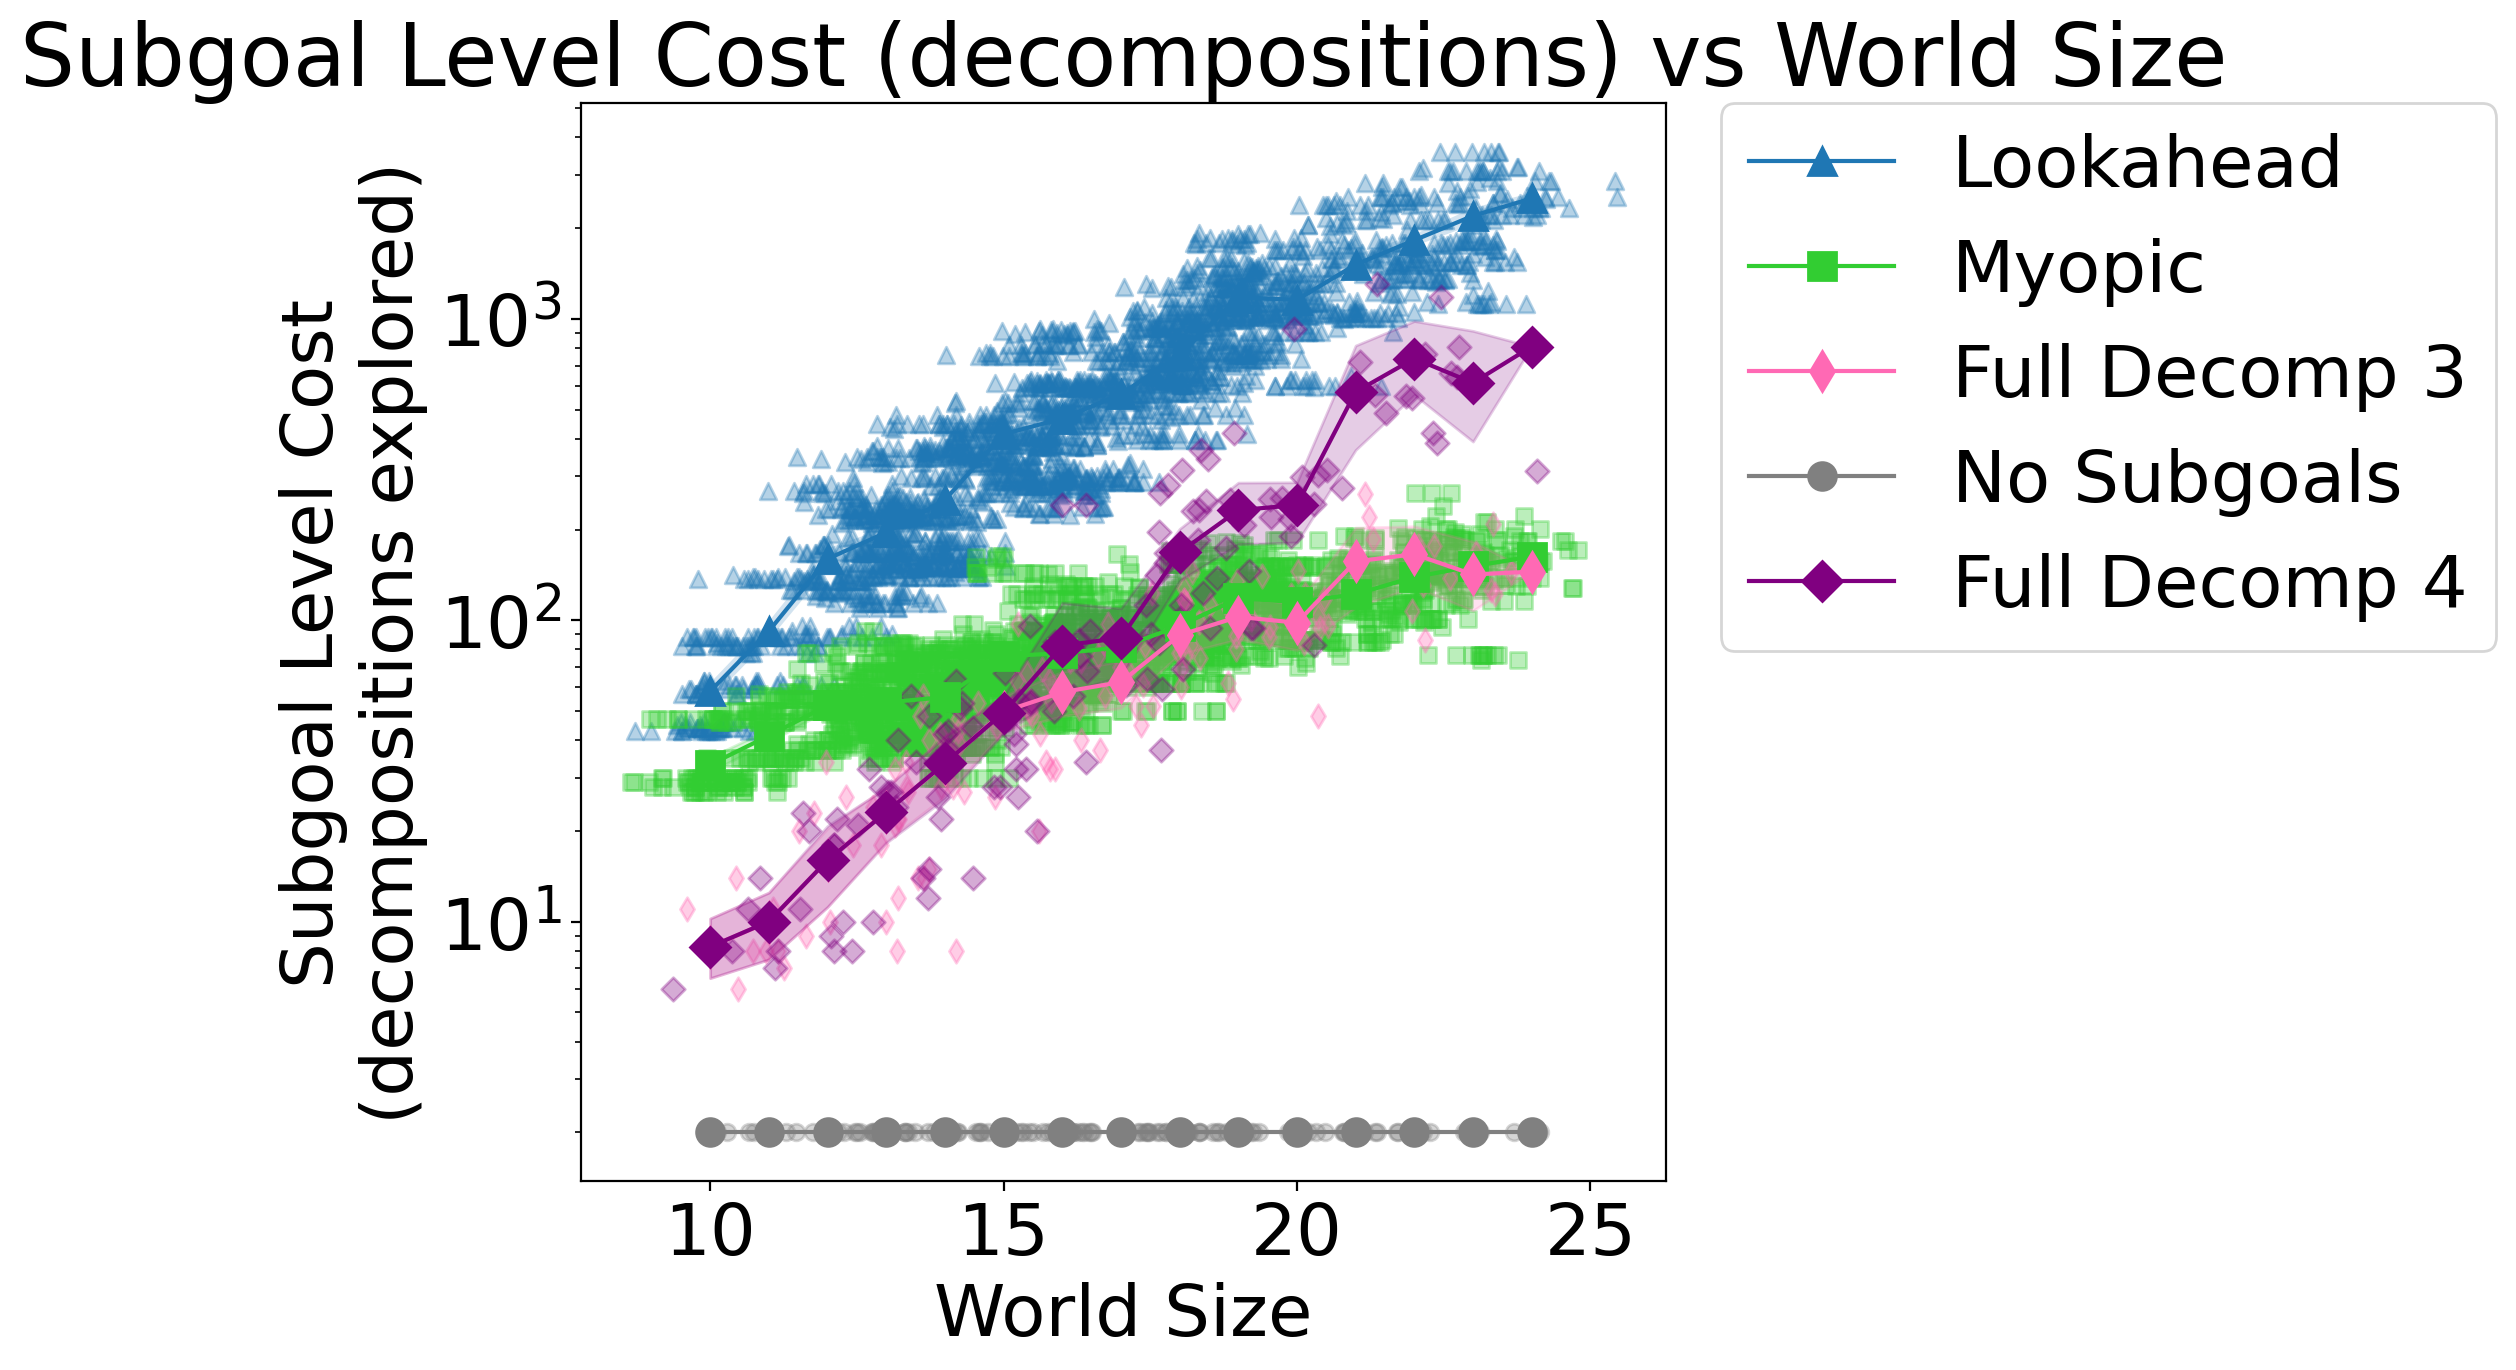

In [45]:
plot = plot_data(
    fdf,
    "world_size item",
    "all_sequences_count sum",
    "World Size",
    "Subgoal Level Cost\n(decompositions explored)",
    "Subgoal Level Cost (decompositions) vs World Size",
)

  0%|          | 0/5 [00:00<?, ?it/s]

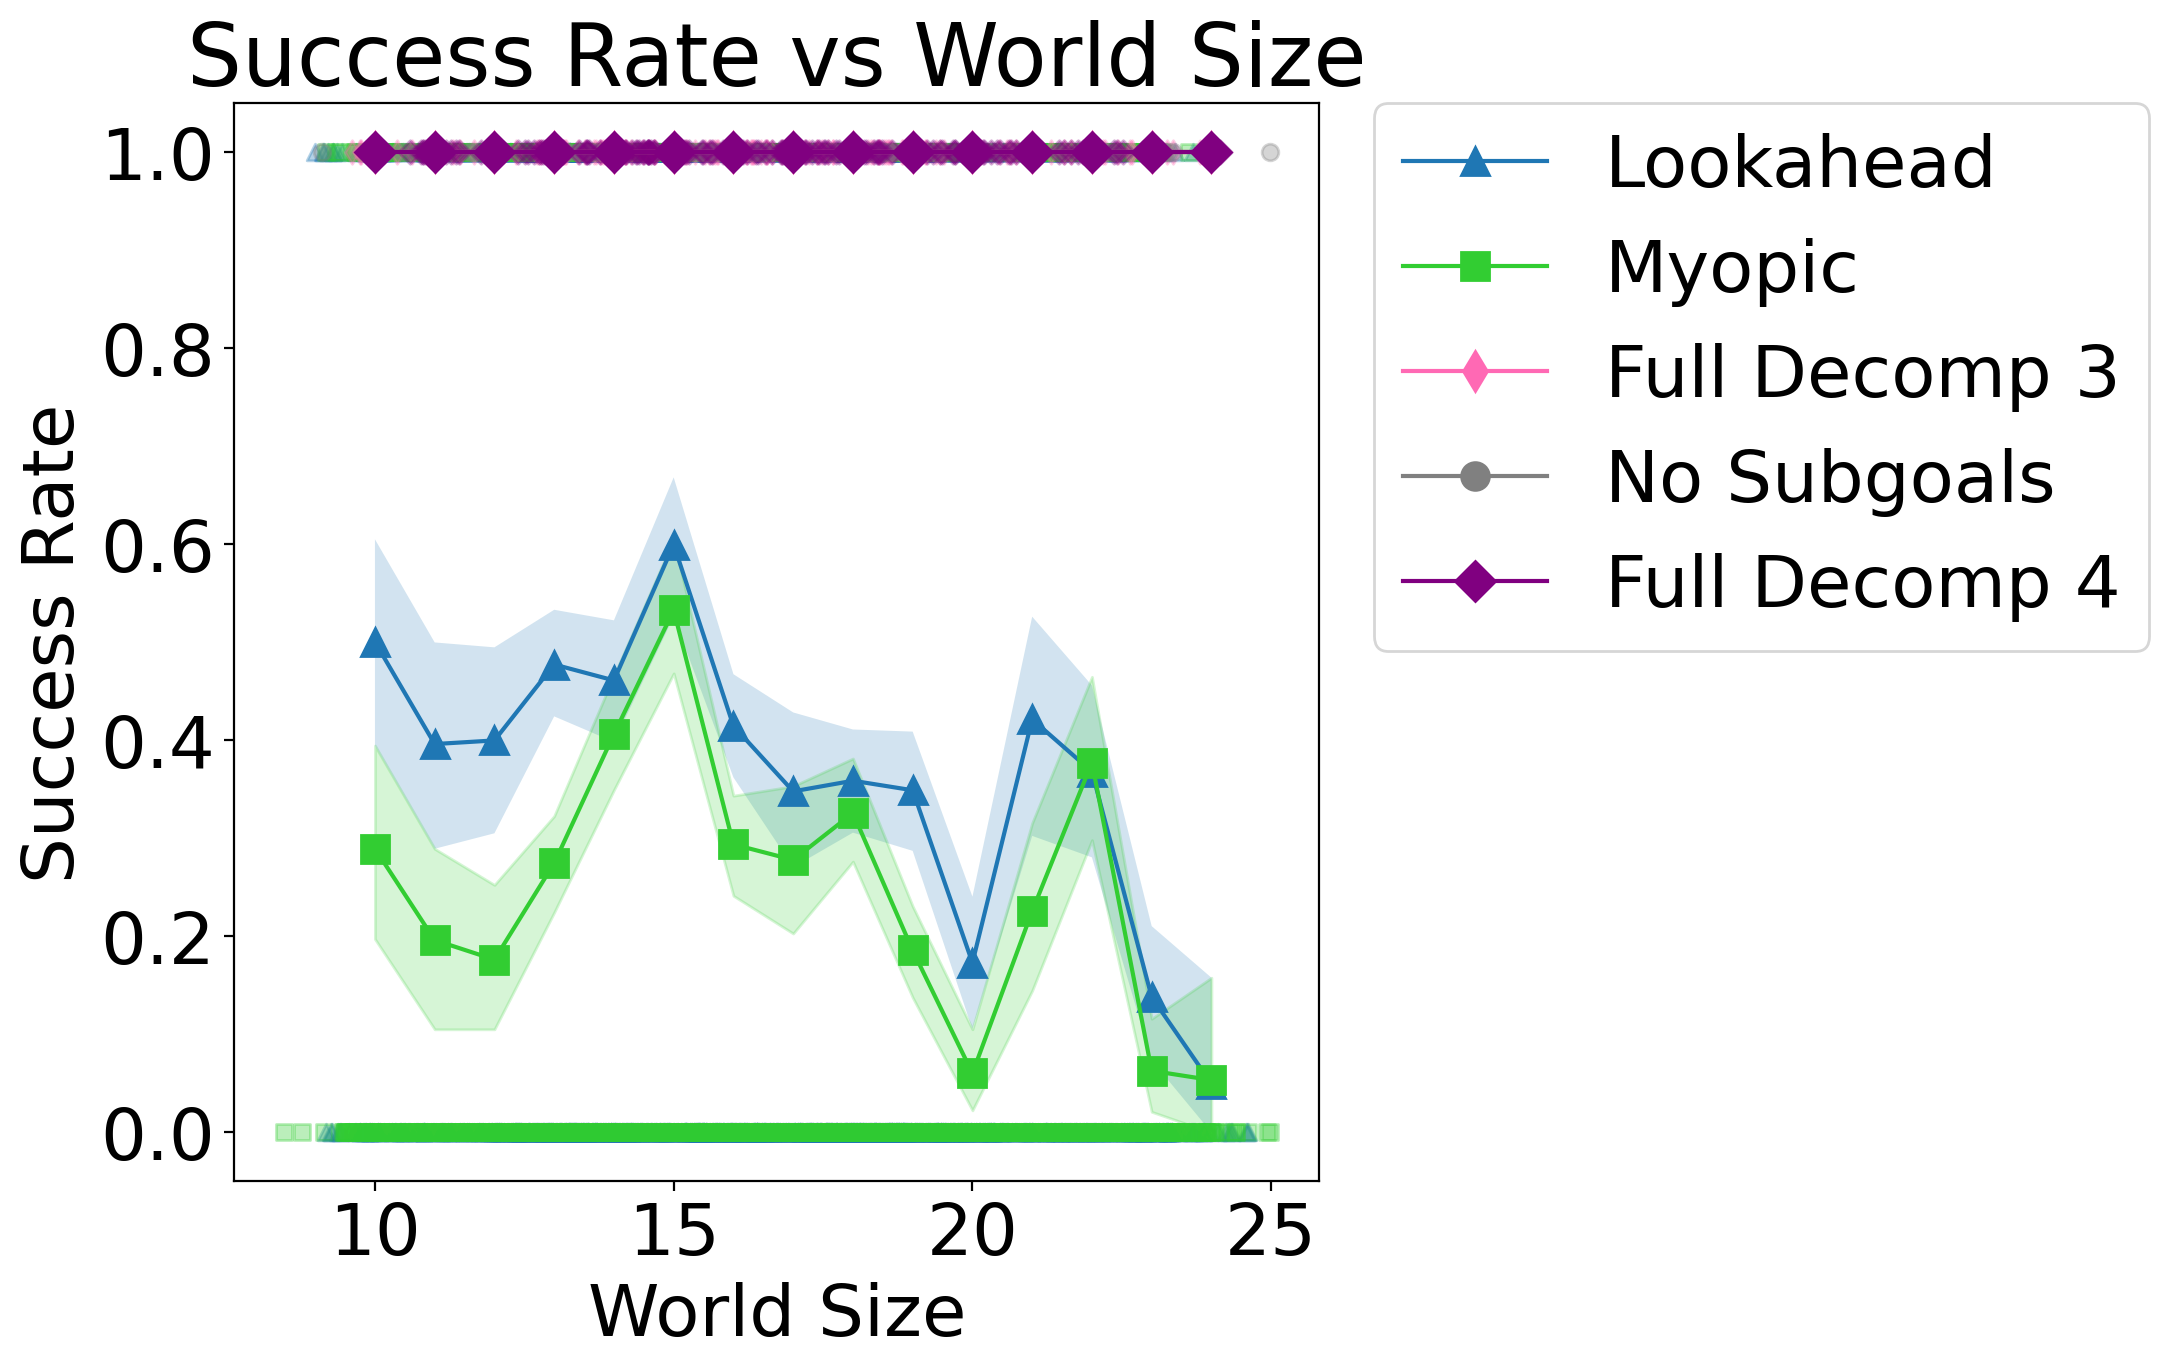

In [46]:
plot = plot_data(
    fdf,
    "world_size item",
    "perfect last",
    "World Size",
    "Success Rate",
    "Success Rate vs World Size",
    y_scale="linear",
)

### High cost avoidance ($\lambda$) indeed leads to cheaper solutions, but also getting stuck more often.

  0%|          | 0/5 [00:00<?, ?it/s]

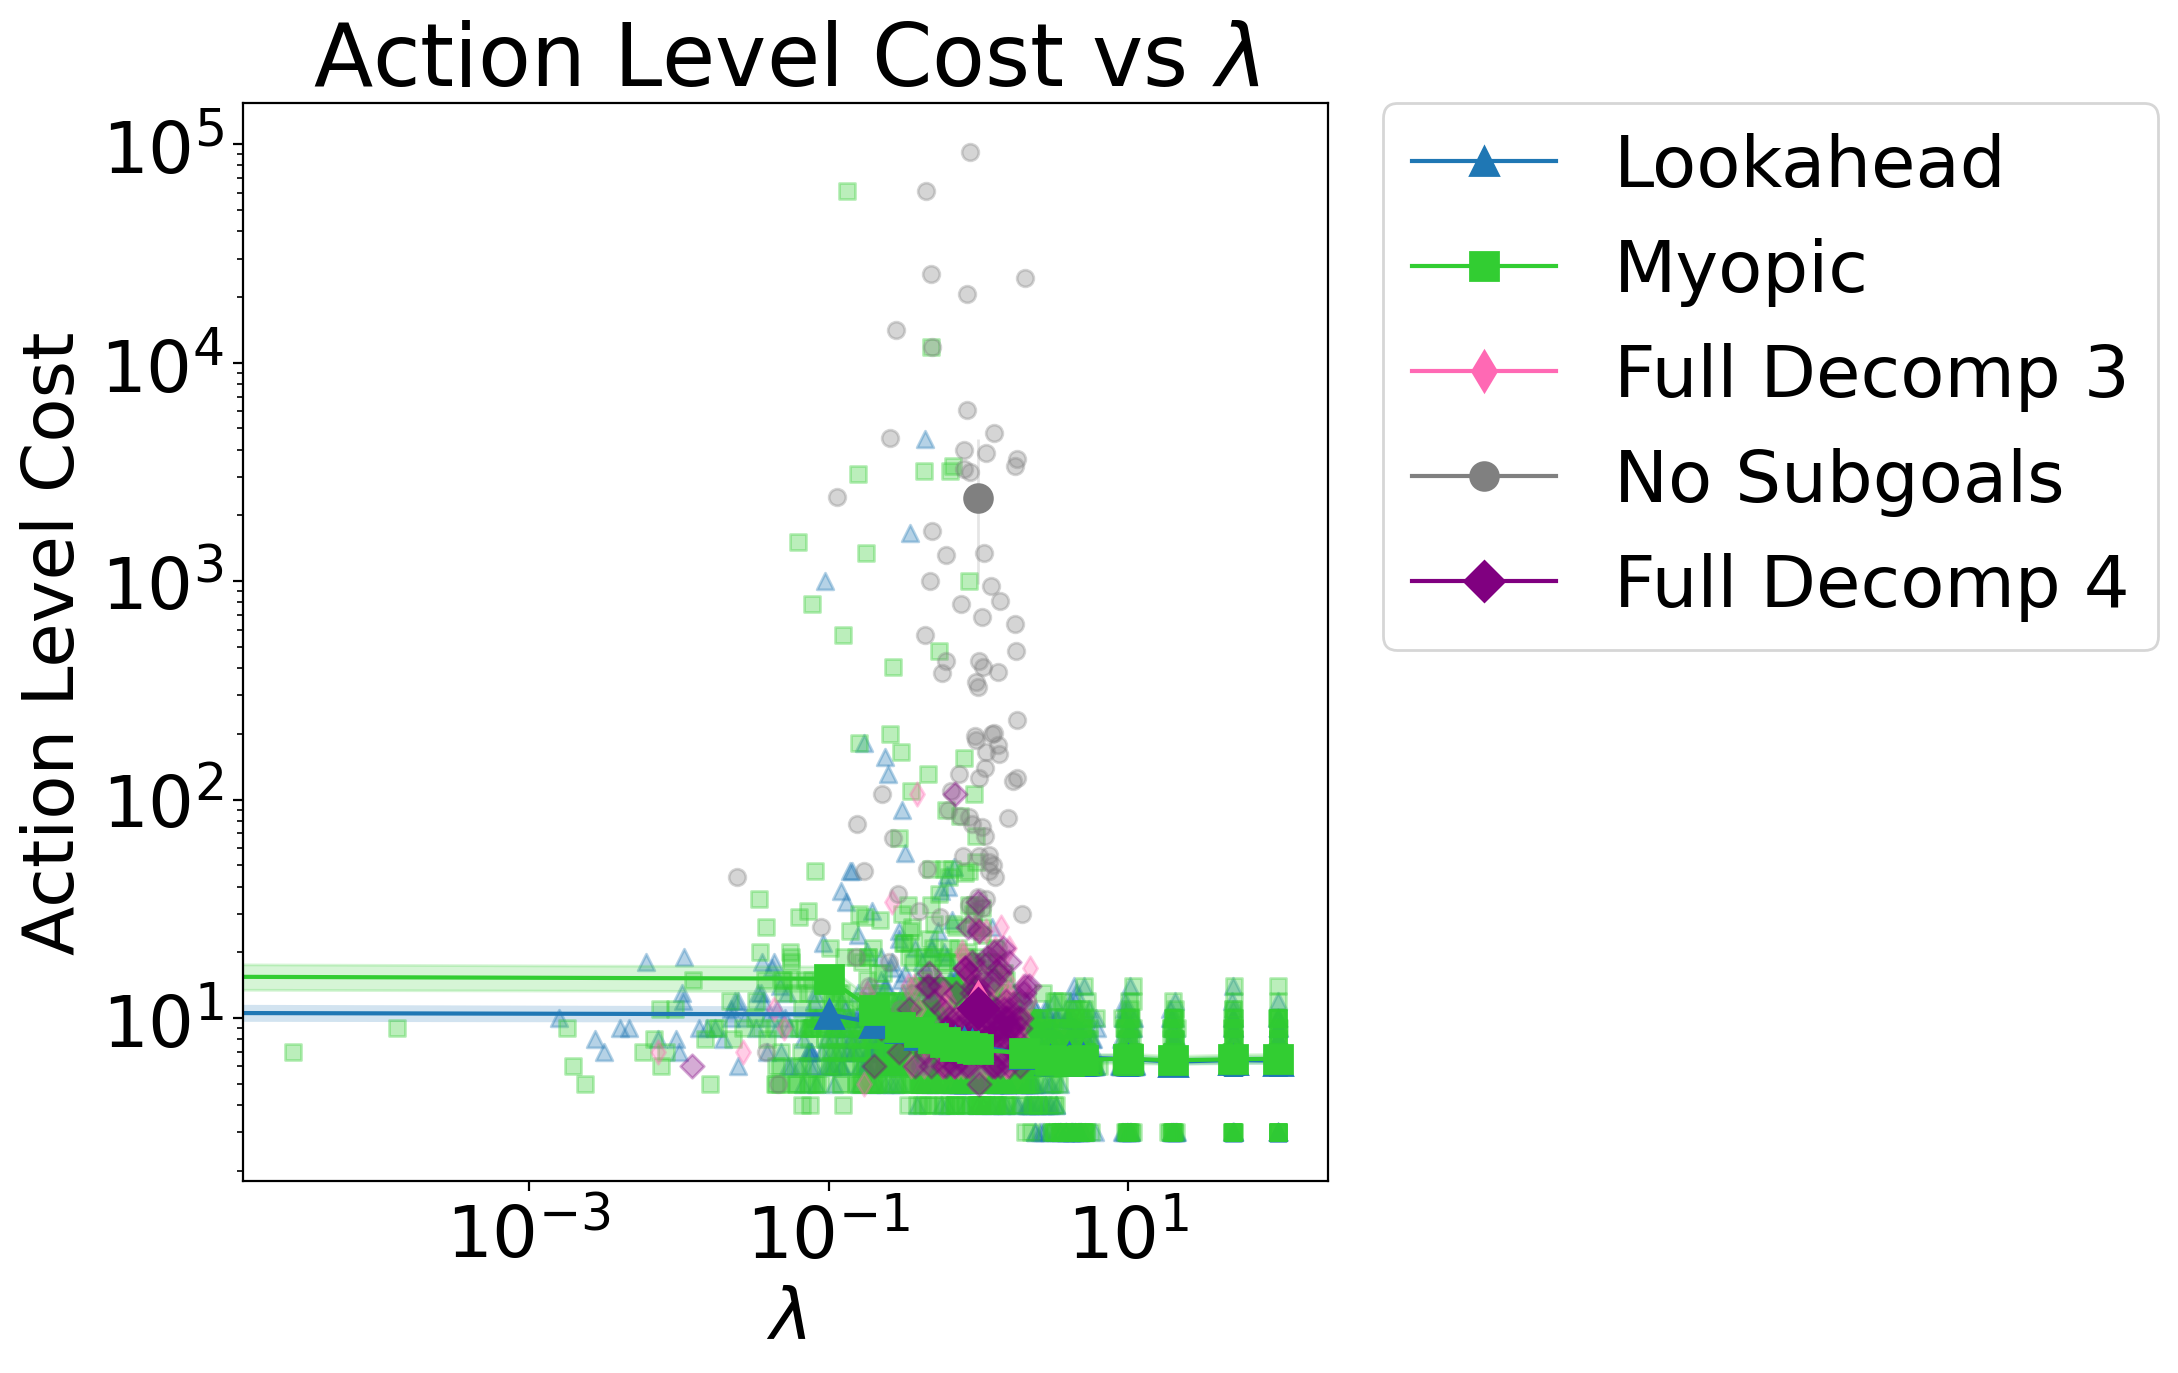

In [47]:
plot = plot_data(
    fdf,
    "c_weight first",
    "cost sum",
    "$\lambda$",
    "Action Level Cost",
    "Action Level Cost vs $\lambda$",
    x_scale="log",
)

  0%|          | 0/5 [00:00<?, ?it/s]

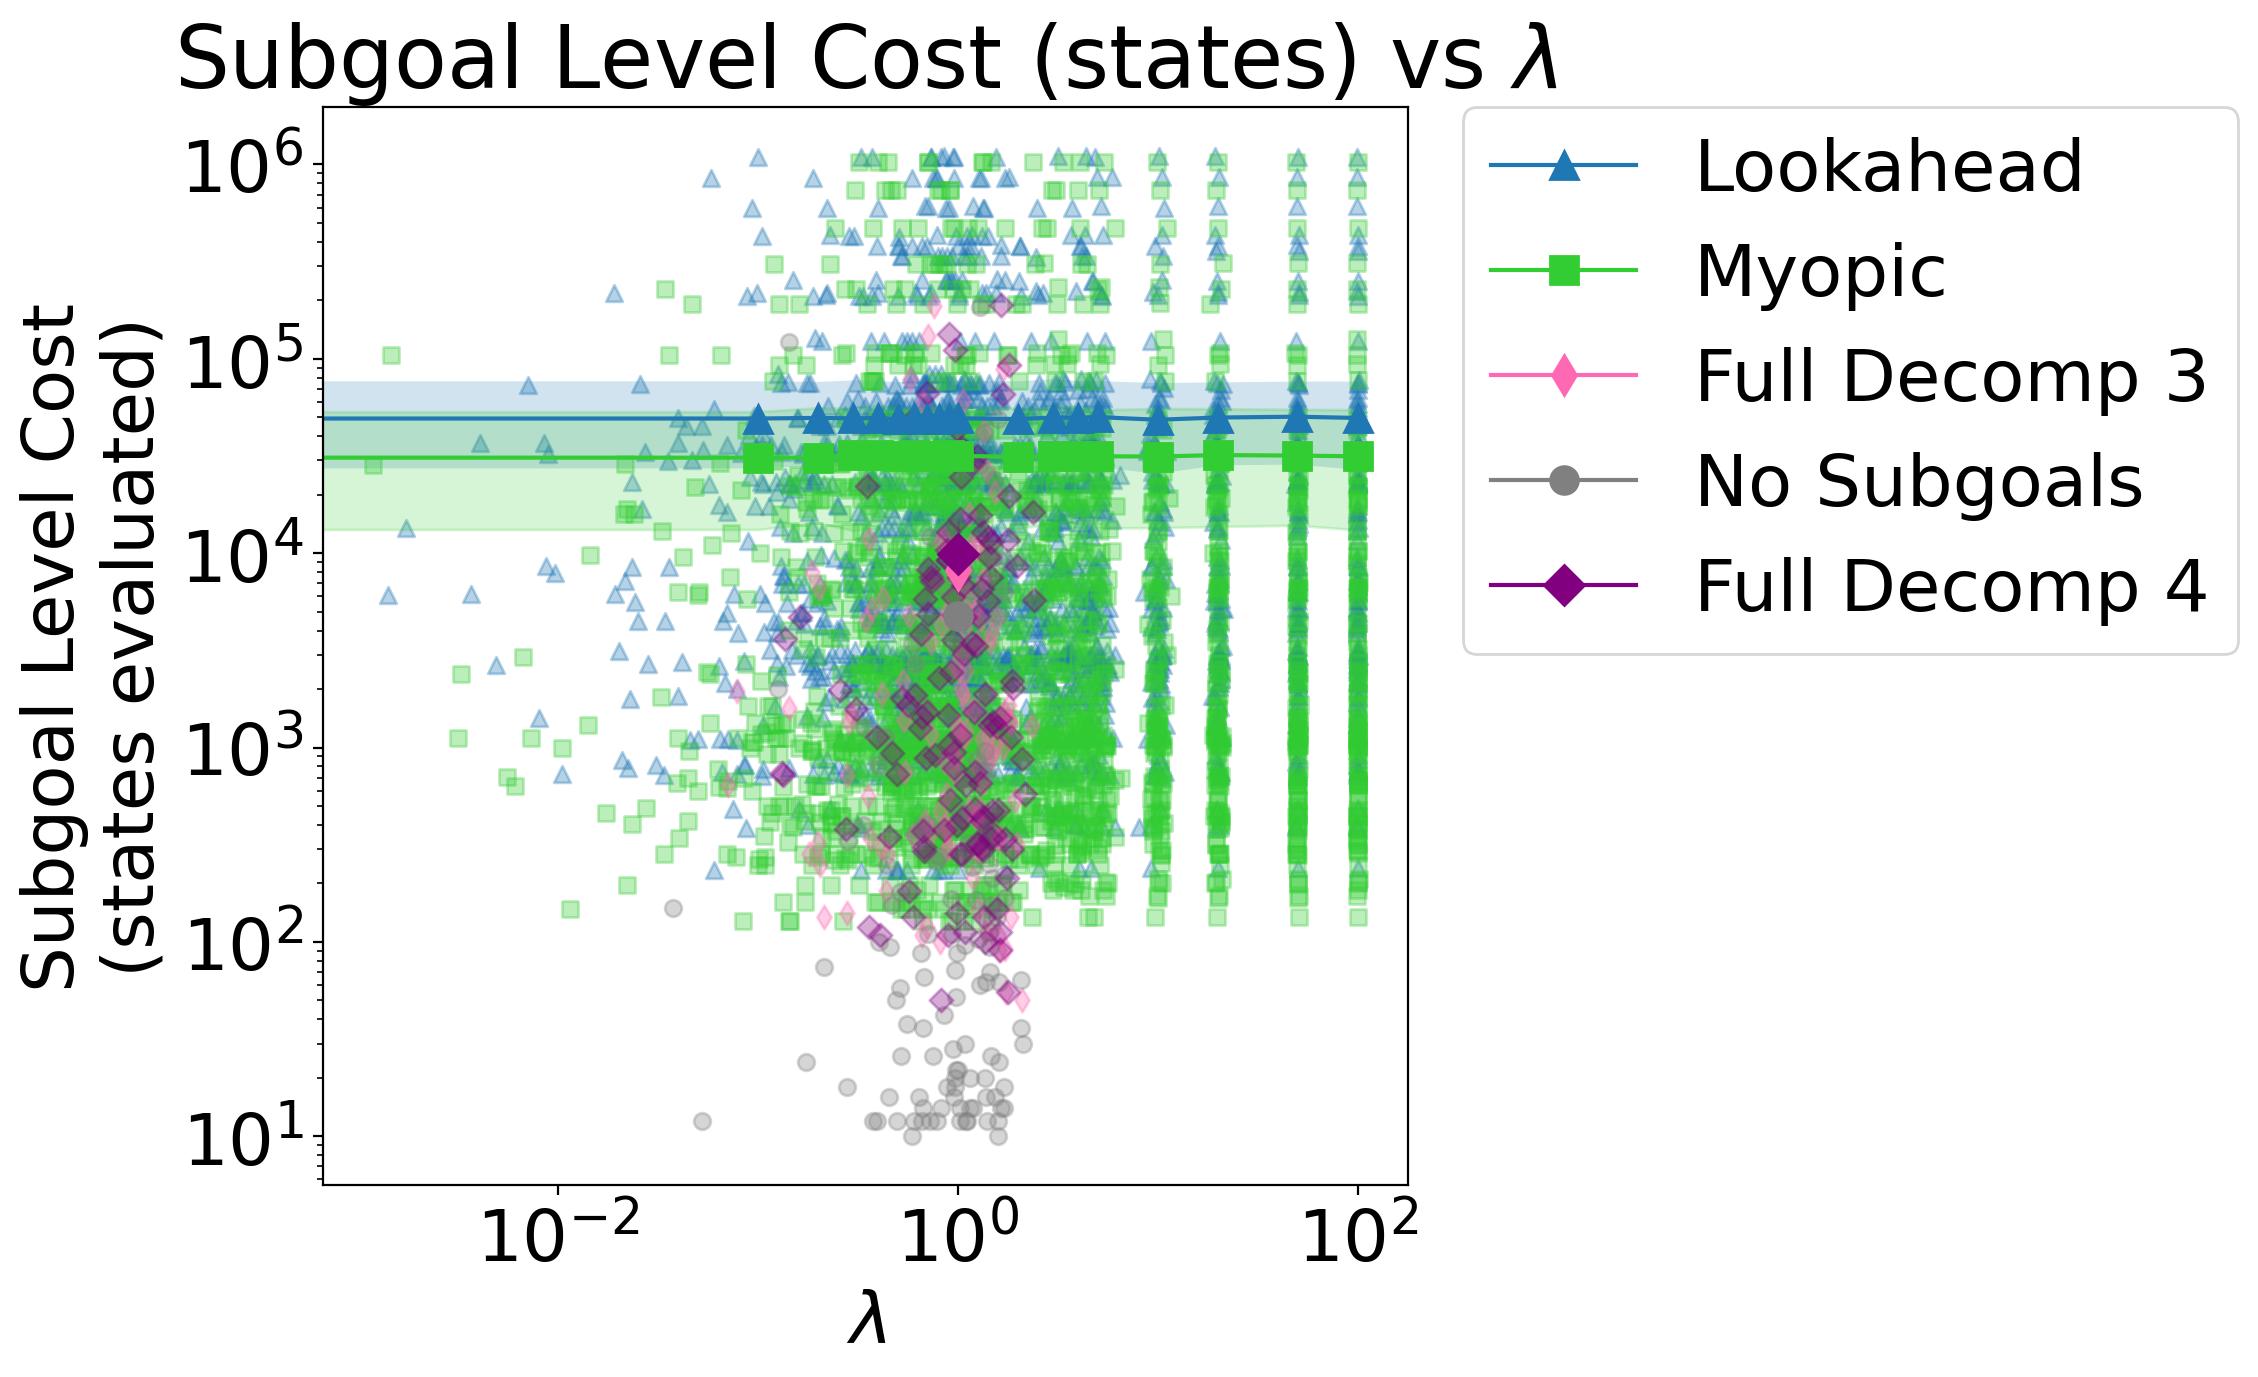

In [48]:
plot = plot_data(
    fdf,
    "c_weight first",
    "total_cost sum",
    "$\lambda$",
    "Subgoal Level Cost\n(states evaluated)",
    "Subgoal Level Cost (states) vs $\lambda$",
    x_scale="log",
)

  0%|          | 0/5 [00:00<?, ?it/s]

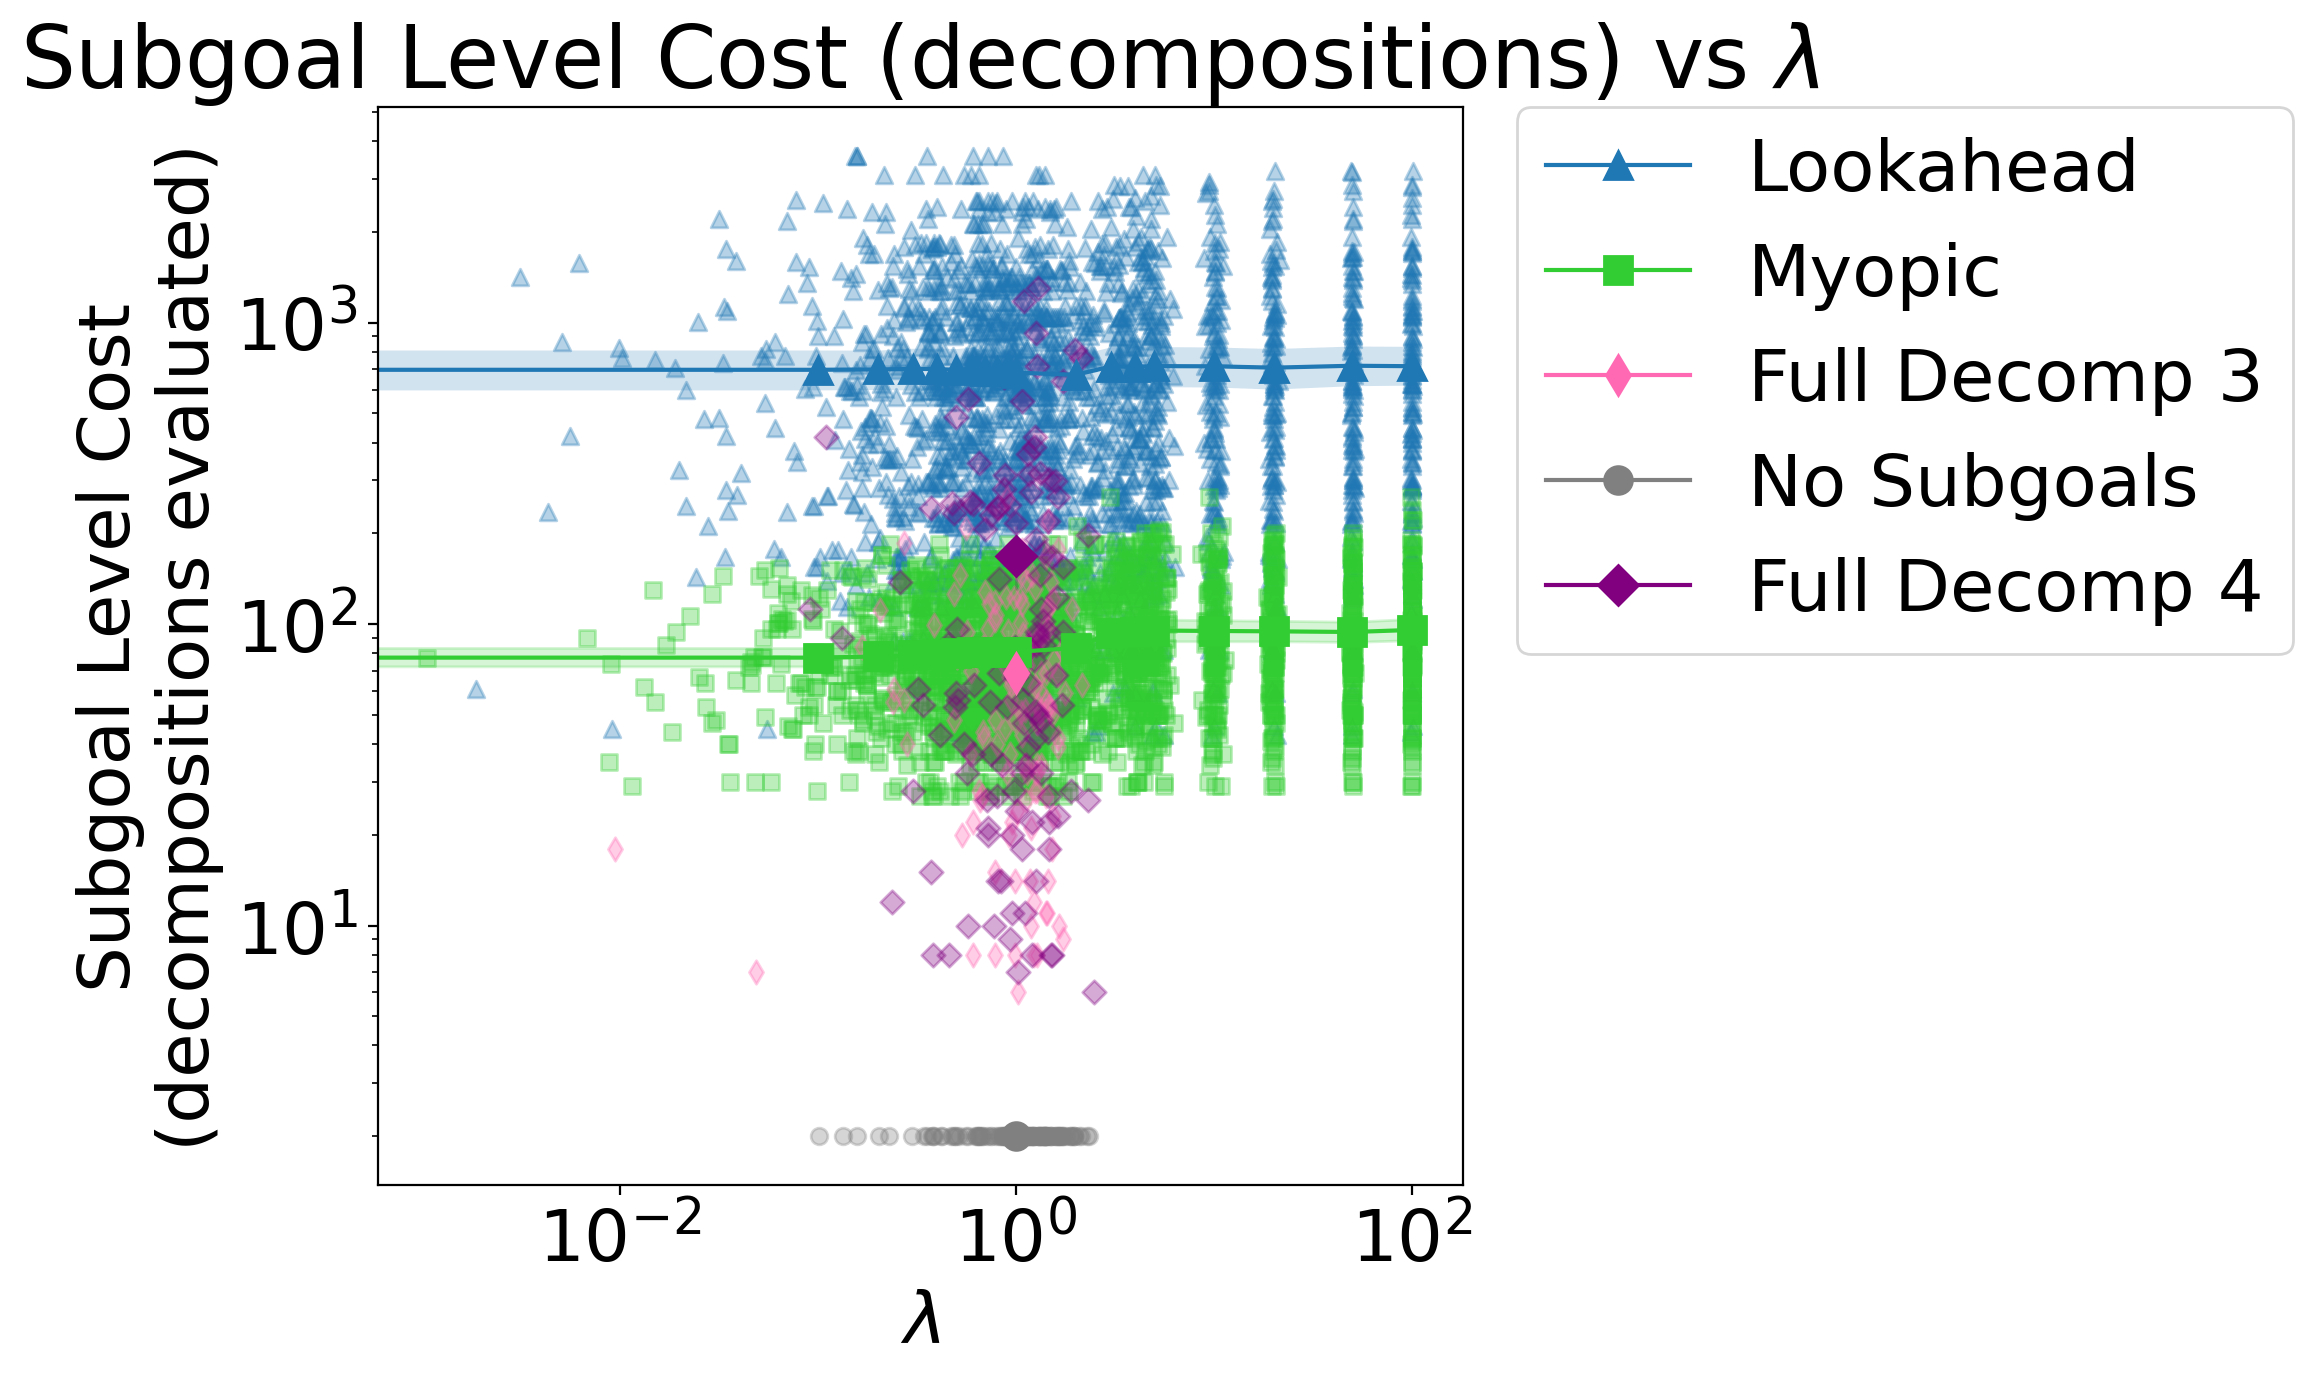

In [49]:
plot = plot_data(
    fdf,
    "c_weight first",
    "all_sequences_count sum",
    "$\lambda$",
    "Subgoal Level Cost\n(decompositions evaluated)",
    "Subgoal Level Cost (decompositions) vs $\lambda$",
    x_scale="log",
)

  0%|          | 0/5 [00:00<?, ?it/s]

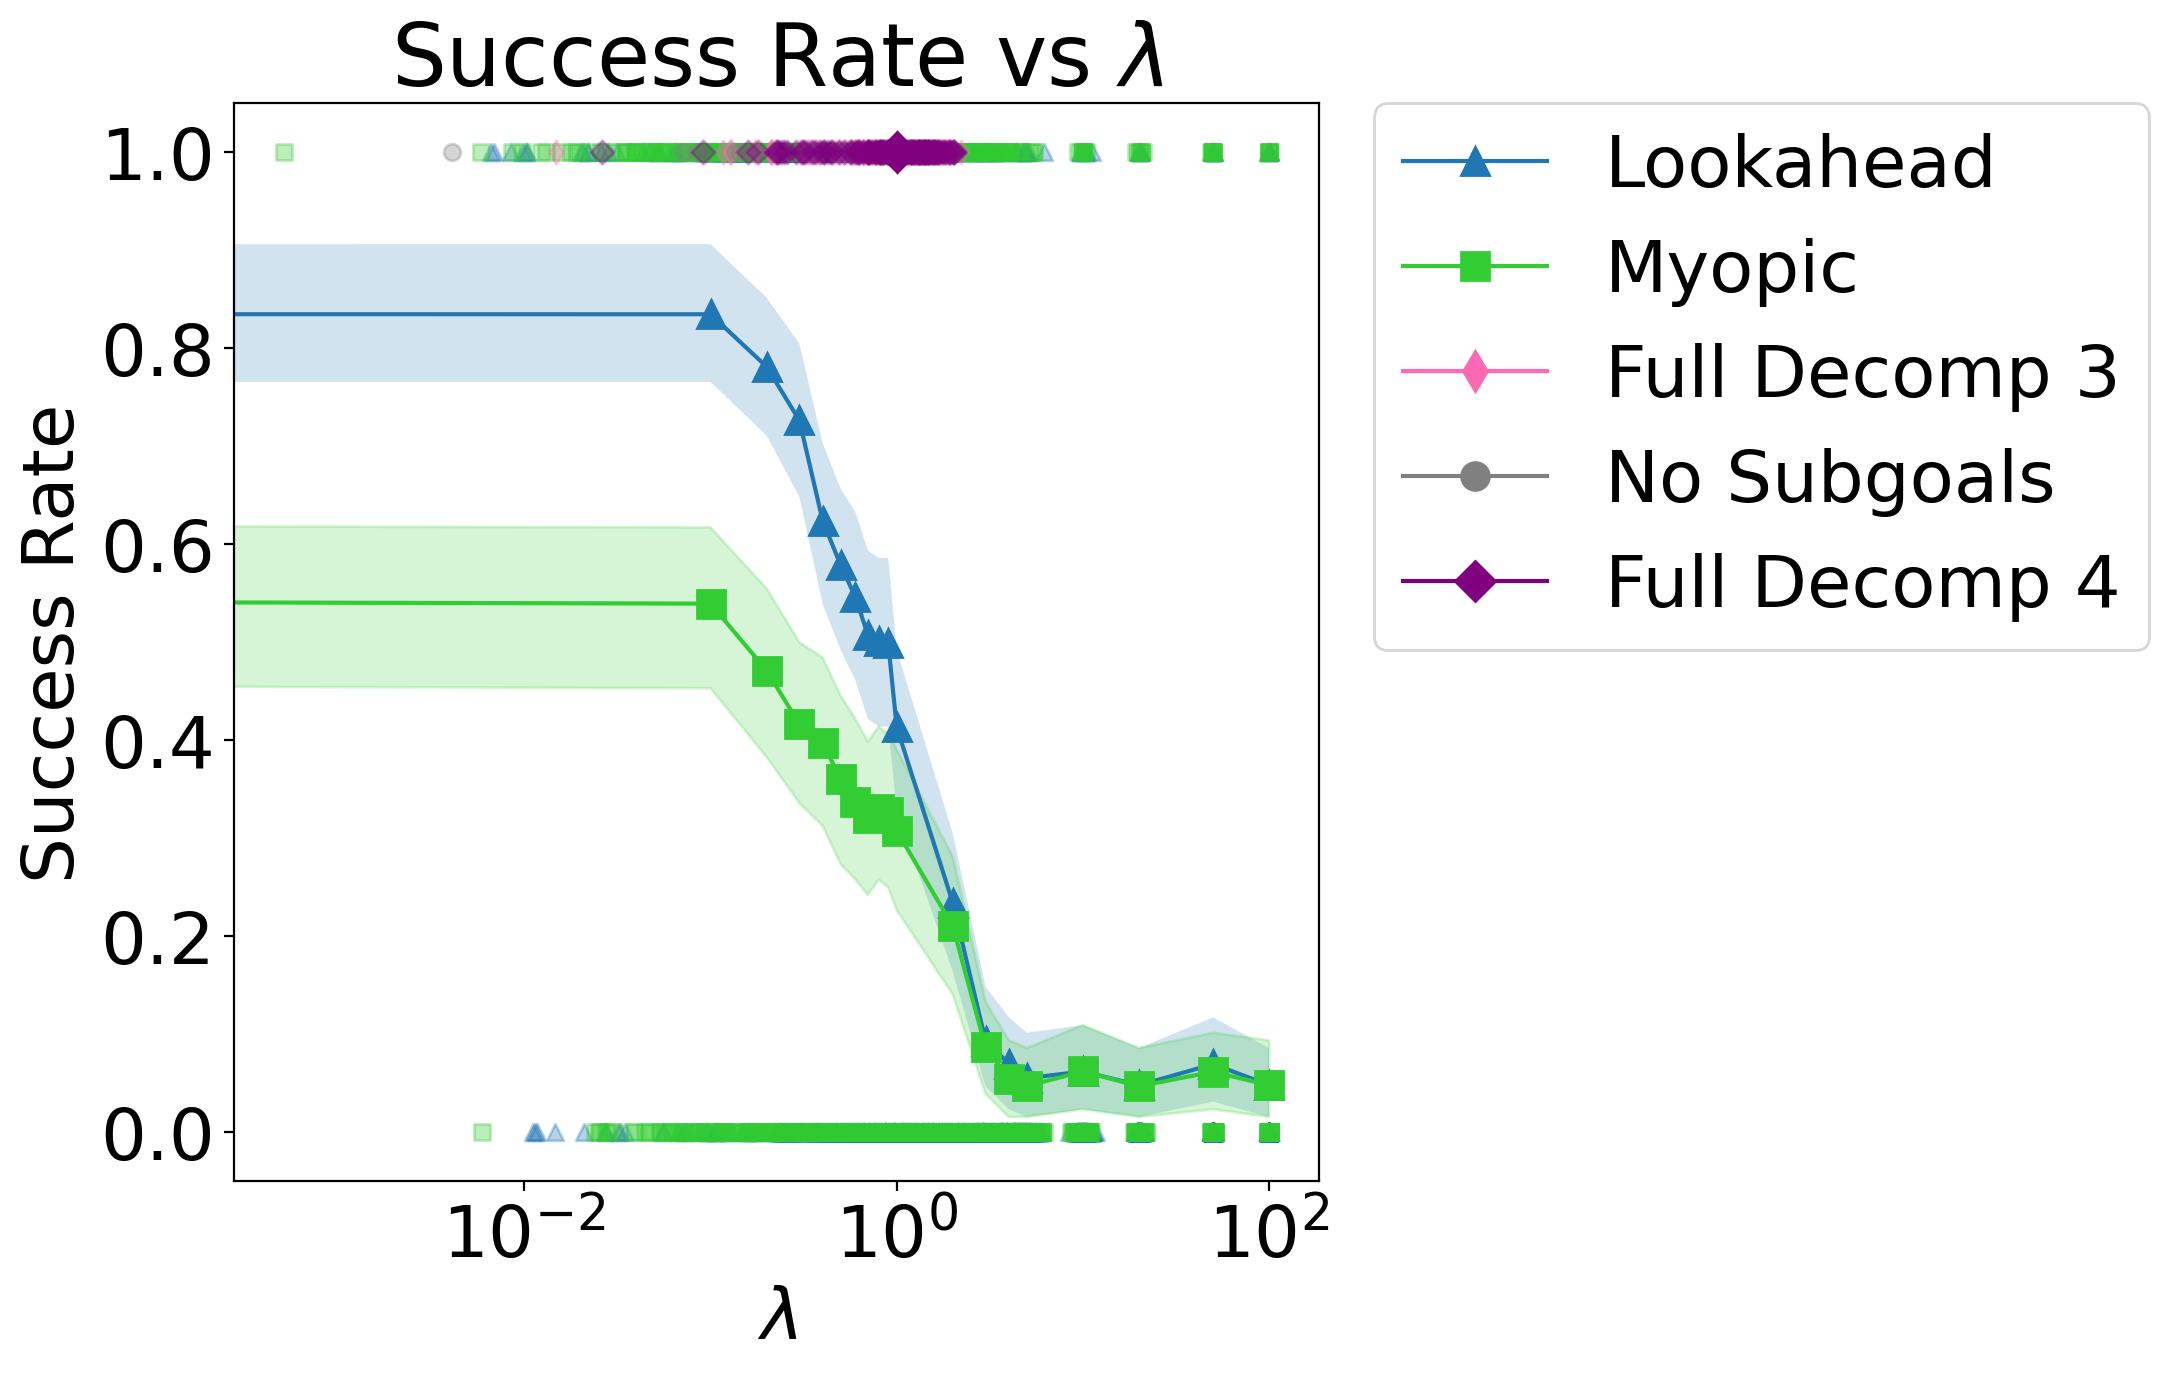

In [50]:
plot = plot_data(
    fdf,
    "c_weight first",
    "perfect last",
    "$\lambda$",
    "Success Rate",
    "Success Rate vs $\lambda$",
    x_scale="log",
    y_scale="linear",
)

### Paradoxically, avoiding action level costs leads to more subgoal selection and therefore higher costs.

# Debugging

In [41]:
id = fdf.iloc[103].run_ID

In [42]:
id

"Blockworld_81_{'agent_type': 'Simulated_Subgoal_Agent', 'c_weight': 1, 'step_size': -1, 'random_seed': 73085, 'label;': 'No Subgoals'} label: No Subgoals0_6324_152"

In [46]:
seq = df[df["run_ID"] == id]["_chosen_subgoal_sequence"].item()

In [53]:
w = df[df["run_ID"] == id]["_world"].item()

In [56]:
import pickle

# pickle to disk
with open("DEBUG world.pkl", "wb") as f:
    pickle.dump(w, f)

In [55]:
df["world"].unique()

array(['Blockworld_81', 'Blockworld_32', 'Blockworld_84', 'Blockworld_28'],
      dtype=object)

In [54]:
df[df["run_ID"] == id]["world"].item()

'Blockworld_81'

In [50]:
seq = seq[0]

In [51]:
seq.subgoals

[]